In [1]:
# to working with graphs
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# to working with financial data
import yfinance as yf

# for building model
from prophet import Prophet

# for data analysis
from pandas.plotting import autocorrelation_plot
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro, boxcox
from sklearn.preprocessing import StandardScaler

# for statical analysis of time series data
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.tsa.api as smt
from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.tsa.seasonal import seasonal_decompose

# for auto arima model
import pmdarima as pm

# graph settings
import warnings
import hvplot.pandas
import hvplot as hv

# warnings
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")


In [2]:
def get_price_data(ticker='META'):
    """
    Retrieves historical stock price data for a given ticker symbol using the Yahoo Finance API.
    
    Parameters:
    - ticker (str, optional): Ticker symbol of the desired stock. Defaults to 'META' if not specified.
    Returns:
    - tickerDf (DataFrame): A Pandas DataFrame containing historical stock price data, including Open, High, Low, Close, and Volume.
    
    Example Usage:
    
    # Example 2: Retrieve Apple Inc. (AAPL) stock price data
    aapl_data = get_price_data(ticker='AAPL')
    """
    
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2023-1-1')
    return tickerDf.iloc[:,:5]

In [3]:
def plot_candlestick(df, ax=None, fmt="%Y-%m-%d"):
    """
    Plots candlestick chart for stock price data.

    Parameters:
    - df (DataFrame): Pandas DataFrame containing stock price data with columns 'Open', 'High', 'Low', 'Close', and a datetime index.
    - ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot the candlestick chart. If not provided, a new subplot will be created.
    - fmt (str, optional): Date format for the x-axis. Defaults to "%Y-%m-%d".
    Returns:
    - ax (matplotlib.axes.Axes): Matplotlib axes containing the candlestick chart.

    Example Usage:
    
    # Assuming 'meta_df' is a DataFrame with required columns and datetime index
    plot_candlestick(meta_df)
    """
    if ax is None:
        fig, ax = plt.subplots()
    idx_name = df.index.name if df.index.name else 'index'
    dat = df.reset_index()[[idx_name, "Open", "High", "Low", "Close"]]
    dat[idx_name] = dat[idx_name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("OHLC")
    return ax

In [4]:
def is_normal(test, p_level=0.05):
    """
    Checks the normality of a statistical test based on its p-value.

    Parameters:
    - test (tuple): Tuple containing the test statistic and p-value.
    - p_level (float, optional): Significance level for the normality test. Defaults to 0.05.
    Returns
    - result (str): String indicating whether the data is considered normal or not based on the p-value.
    Example Usage:

    # Assuming 'shapiro_test' is a tuple with the test statistic and p-value
    result = is_normal(shapiro_test)
    """
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [5]:
def adfuller_stationarity(timeseries):
    """
    Performs the Augmented Dickey-Fuller test for stationarity on a given time series and prints the results.

    Parameters:
    - timeseries (pd.Series): Pandas Series representing the time series data.

    Example Usage:
    
    # Assuming 'my_timeseries' is a Pandas Series
    adfuller_stationarity(my_timeseries)
    """
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

In [6]:
def kpss_test(timeseries):
    """
    Performs the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity on a given time series and prints the results.

    Parameters:
    - timeseries (pd.Series): Pandas Series representing the time series data.

    Example Usage:
    
    # Assuming 'my_timeseries' is a Pandas Series
    kpss_test(my_timeseries)
    """
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    """
    Generates a time series plot along with autocorrelation and partial autocorrelation plots.

    Parameters:
    - y (pd.Series or array-like): Time series data to be plotted.
    - lags (int or None, optional): Number of lags to include in autocorrelation plots. Defaults to None.
    - figsize (tuple, optional): Size of the entire figure. Defaults to (14, 8).
    - style (str, optional): Matplotlib style to apply to the plots. Defaults to 'bmh'.

    Example Usage:
    
    # Assuming 'my_timeseries' is a Pandas Series
    tsplot(my_timeseries, lags=40)
    """
    adfuller_stationarity(y)
    kpss_test(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()

In [8]:
 def series_decompose(series,period=30):
    """
    Decomposes a time series into its trend, seasonal, and residual components using seasonal decomposition.

    Parameters:
    - series (pd.Series): Time series data to be decomposed.
    - period (int, optional): Periodicity of the seasonal component. Defaults to 30.

    Example Usage:
    
    # Assuming 'my_timeseries' is a Pandas Series
    series_decompose(my_timeseries, period=30)
    """
    
    result = seasonal_decompose(series, model='multiplicative', period=period)

    plt.figure(figsize=(12, 8))
    
    plt.subplot(4, 1, 1)
    plt.plot(series, label='Original')
    plt.legend()
    
    plt.subplot(4, 1, 2)
    plt.plot(result.trend, label='Trend')
    plt.legend()
    
    plt.subplot(4, 1, 3)
    plt.plot(result.seasonal, label='Seasonal')
    plt.legend()
    
    plt.subplot(4, 1, 4)
    plt.plot(result.resid, label='Residuals')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# META analysis

In [9]:
meta_df = get_price_data()

In [10]:
meta_df.head()

Open        High         Low       Close  \
Date                                                                        
2017-01-03 00:00:00-05:00  116.029999  117.839996  115.510002  116.860001   
2017-01-04 00:00:00-05:00  117.550003  119.660004  117.290001  118.690002   
2017-01-05 00:00:00-05:00  118.860001  120.949997  118.320000  120.669998   
2017-01-06 00:00:00-05:00  120.980003  123.879997  120.029999  123.410004   
2017-01-09 00:00:00-05:00  123.550003  125.430000  123.040001  124.900002   

                             Volume  
Date                                 
2017-01-03 00:00:00-05:00  20663900  
2017-01-04 00:00:00-05:00  19630900  
2017-01-05 00:00:00-05:00  19492200  
2017-01-06 00:00:00-05:00  28545300  
2017-01-09 00:00:00-05:00  22880400

In [11]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1510 entries, 2017-01-03 00:00:00-05:00 to 2022-12-30 00:00:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1510 non-null   float64
 1   High    1510 non-null   float64
 2   Low     1510 non-null   float64
 3   Close   1510 non-null   float64
 4   Volume  1510 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


<Axes: xlabel='Close', ylabel='Count'>

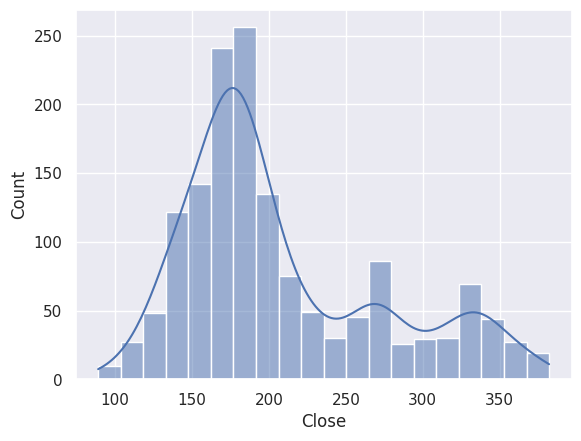

In [12]:
sns.histplot(meta_df,x='Close',kde=True)

In [13]:
print(is_normal(shapiro(meta_df['Close'])))
print(is_normal(kstest_normal(meta_df['Close'])))

Not Normal
Not Normal


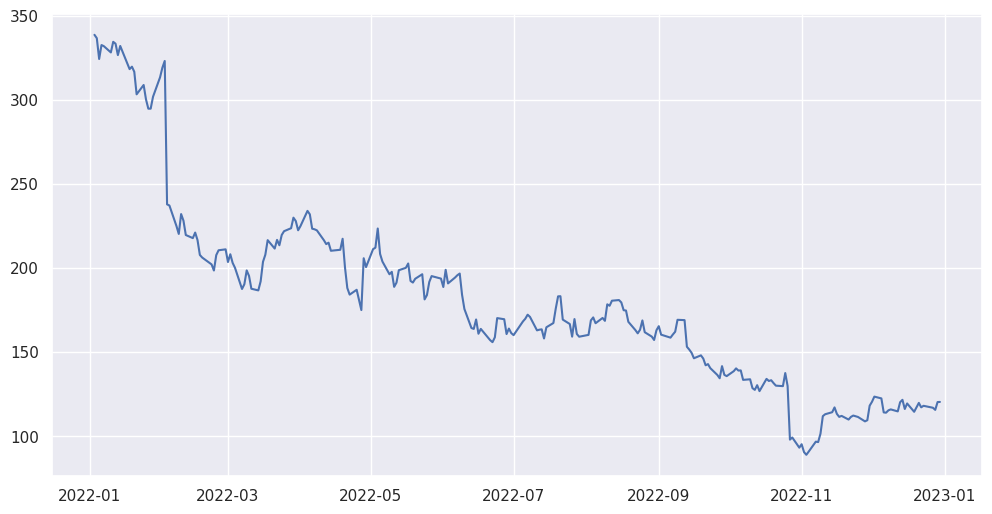

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(meta_df['2022-1-1':'2022-12-30']['Close'])
plt.show()

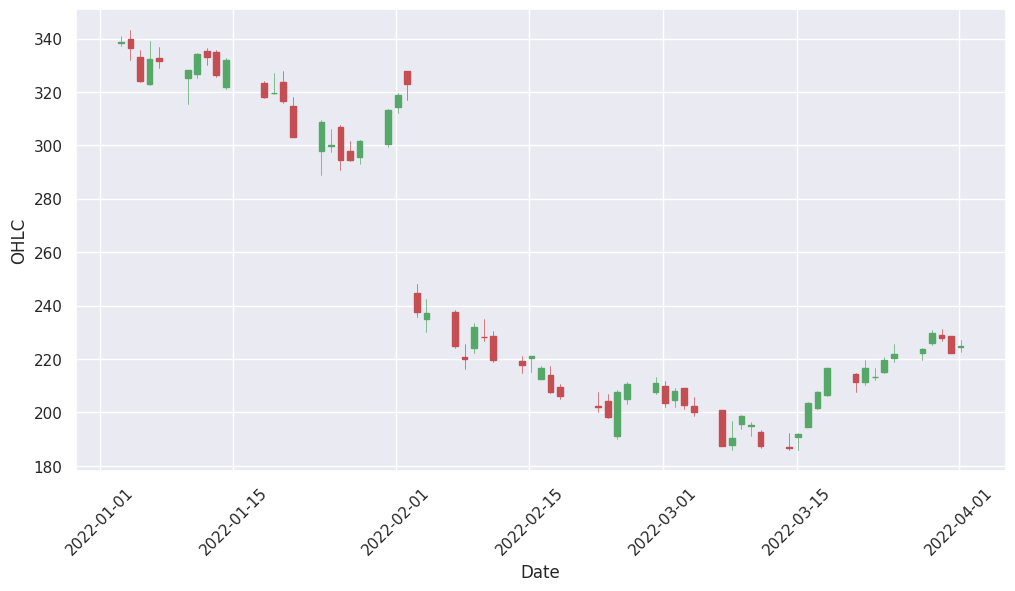

In [15]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(meta_df['2022-01-01':'2022-04-01'], fig.subplots())
plt.show()

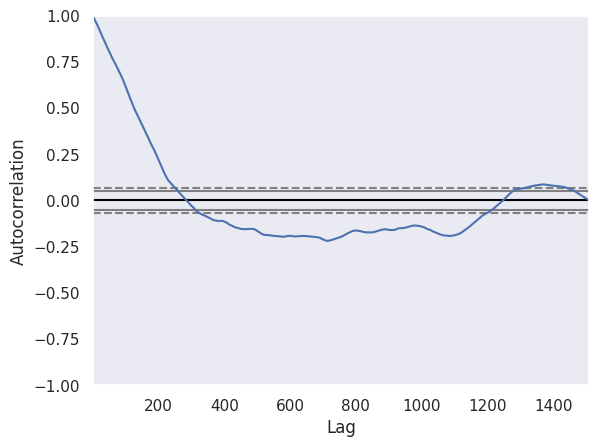

In [16]:
autocorrelation_plot(meta_df['Close'])
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -1.270556
p-value                           0.642533
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            2.061724
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


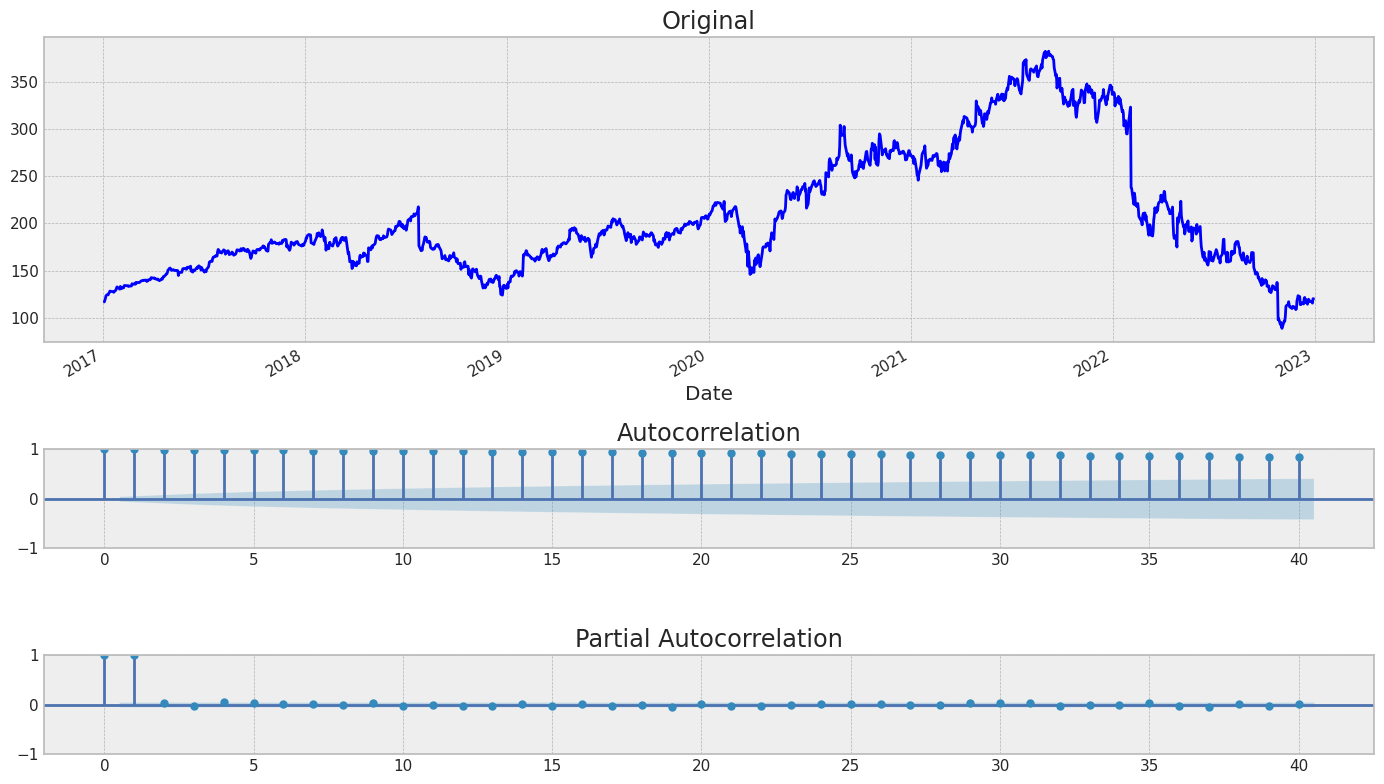

In [17]:
tsplot(meta_df['Close'],lags=40)

In [18]:
meta_df['Close'].hvplot.line(title="META daily close price 2017-2023", width=1300, height=600, by=['index.year'])

:NdOverlay   [index.year]
   :Curve   [Date]   (Close)

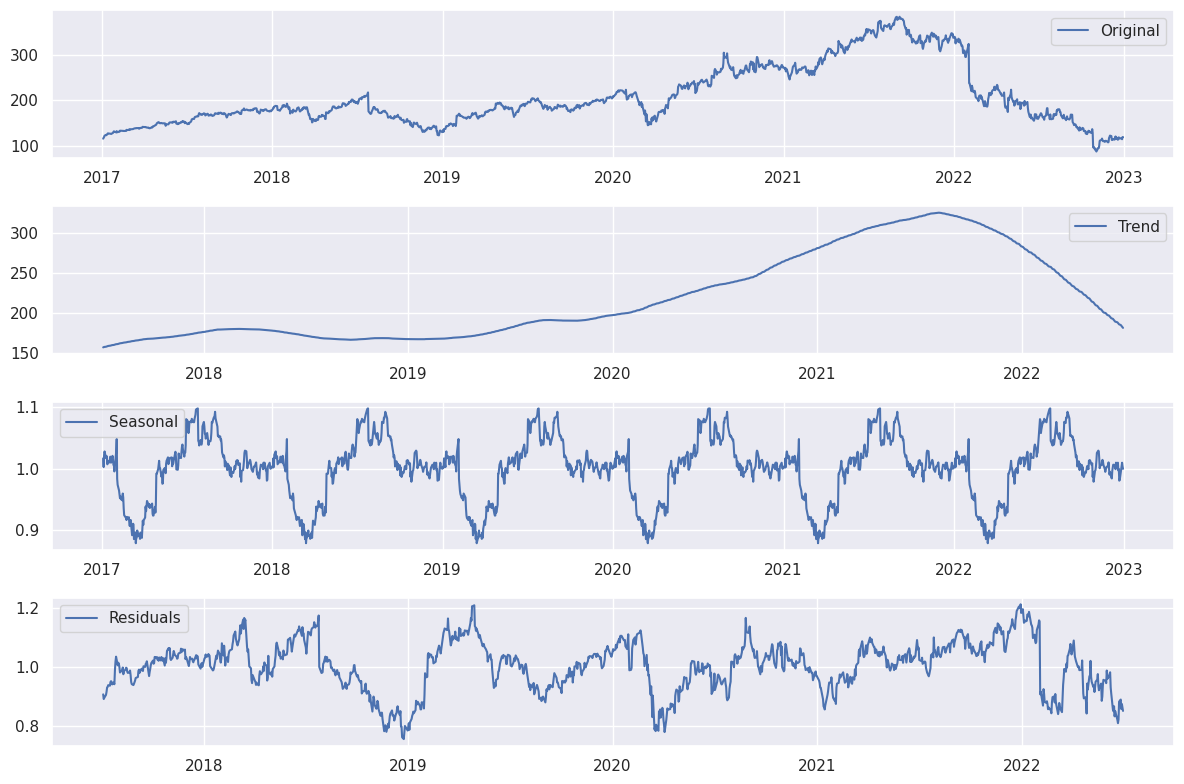

In [19]:
series_decompose(meta_df['Close'],period=252)

## Make stationarity

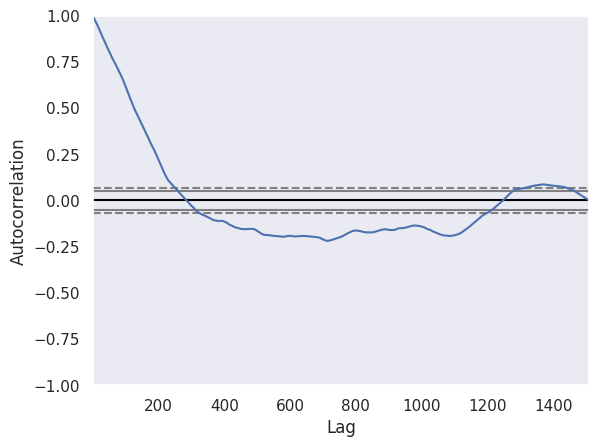

In [20]:
autocorrelation_plot(meta_df['Close'])
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -1.270556
p-value                           0.642533
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            2.061724
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


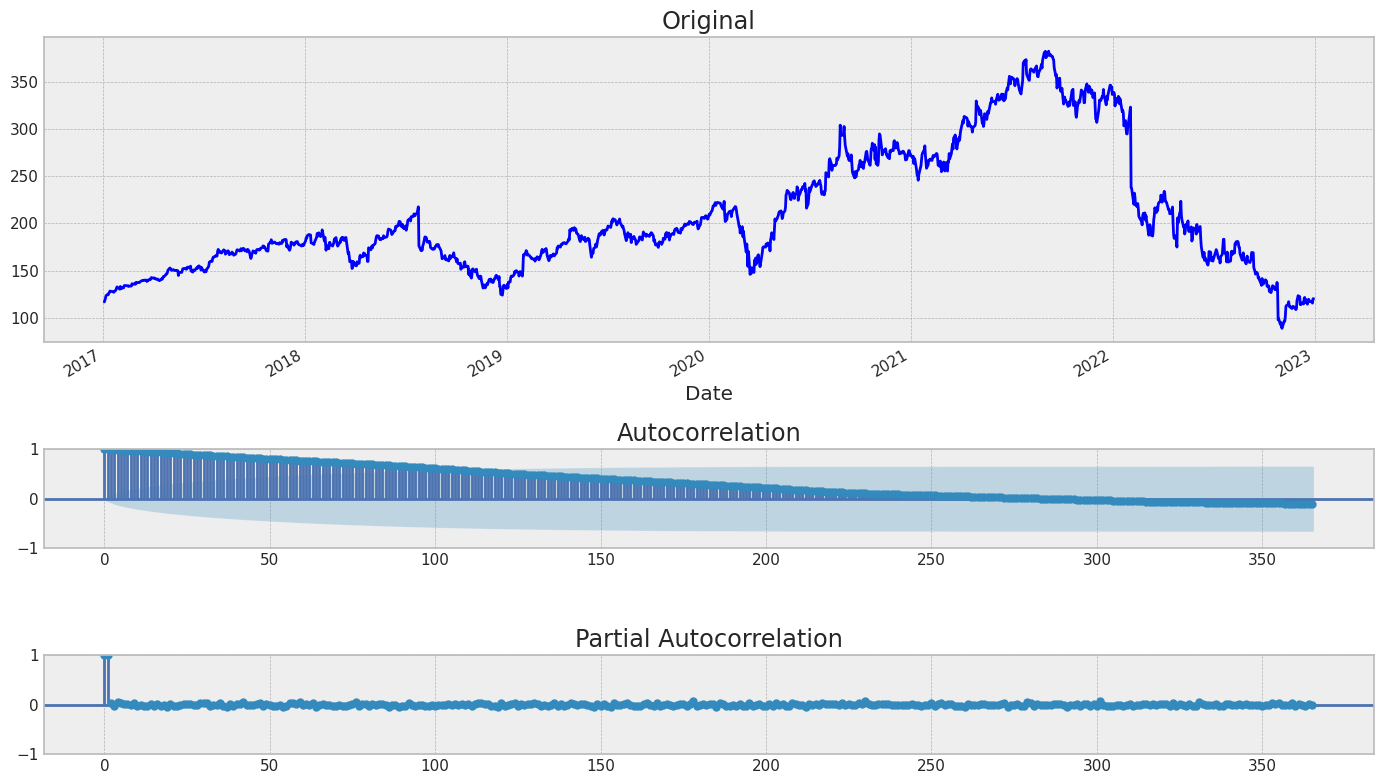

In [21]:
tsplot(meta_df['Close'],lags=365)

Results of Dickey-Fuller Test:
Test Statistic                   -1.270556
p-value                           0.642533
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            2.061724
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


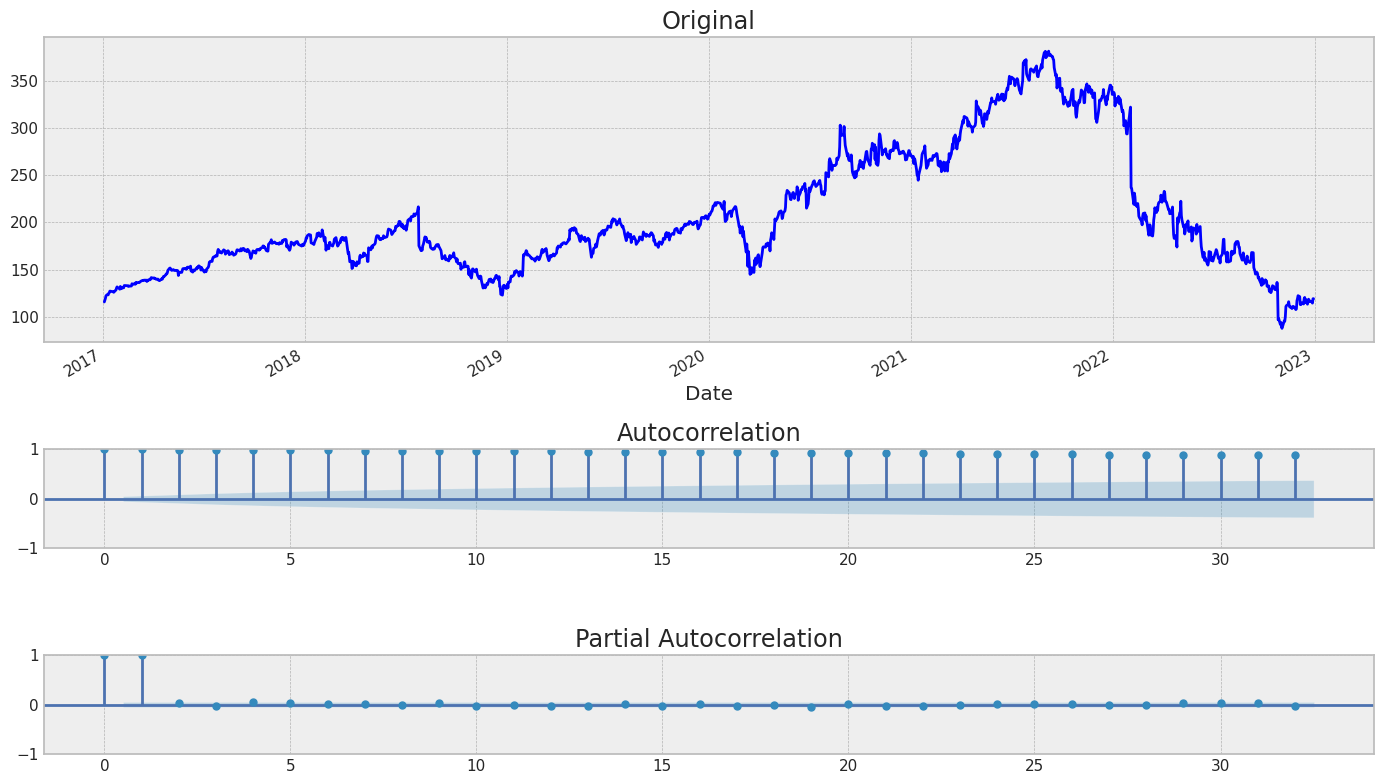

In [22]:
meta_df['Close_boxcox'] = boxcox(meta_df['Close'], 1)
tsplot(meta_df['Close_boxcox'])


Results of Dickey-Fuller Test:
Test Statistic                   -1.239600
p-value                           0.656333
#Lags Used                       10.000000
Number of Observations Used    1499.000000
Critical Value (1%)              -3.434720
Critical Value (5%)              -2.863470
Critical Value (10%)             -2.567798
dtype: float64
Results of KPSS Test:
Test Statistic            1.910976
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


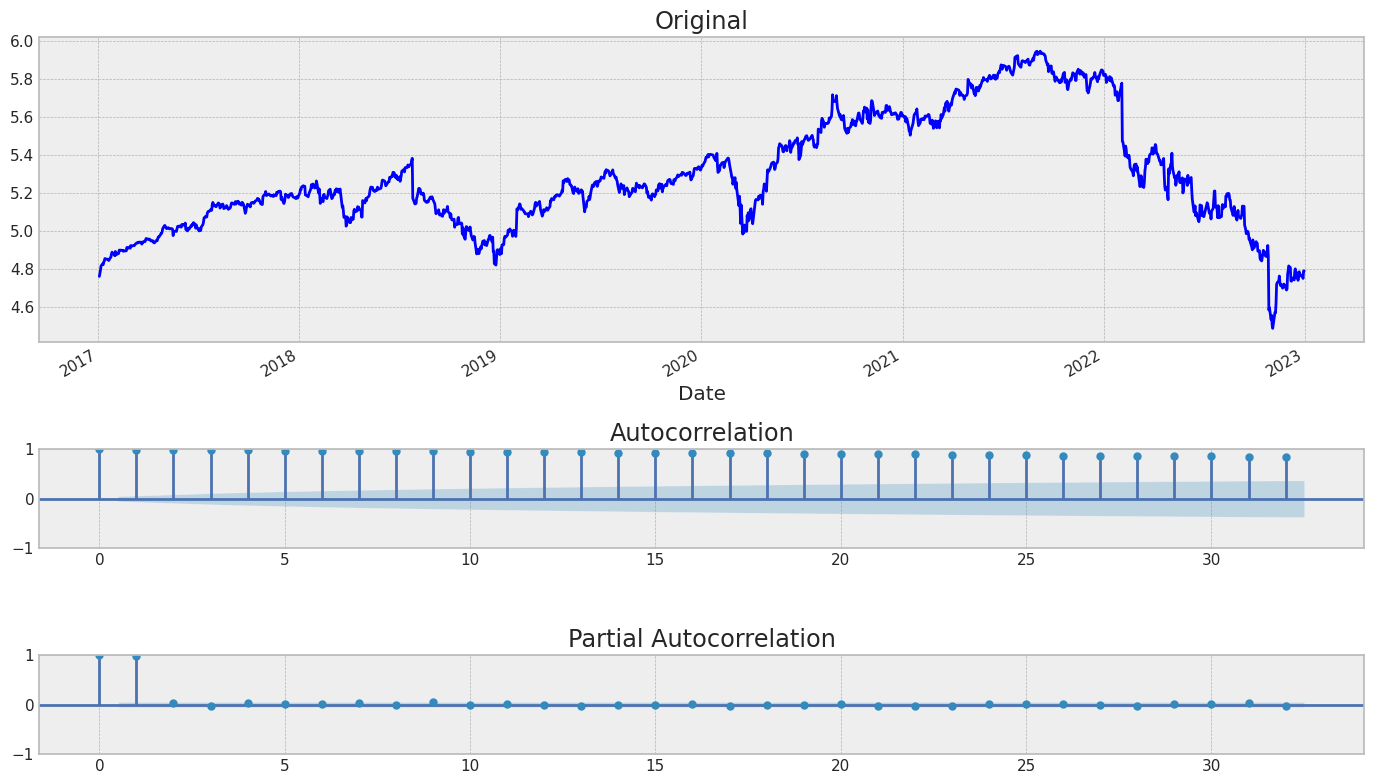

In [23]:
meta_df['Close_log'] = np.log(meta_df['Close'])
tsplot(meta_df['Close_log'])

Results of Dickey-Fuller Test:
Test Statistic                -1.377230e+01
p-value                        9.631894e-26
#Lags Used                     8.000000e+00
Number of Observations Used    1.501000e+03
Critical Value (1%)           -3.434714e+00
Critical Value (5%)           -2.863467e+00
Critical Value (10%)          -2.567796e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.357763
p-value                   0.095361
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


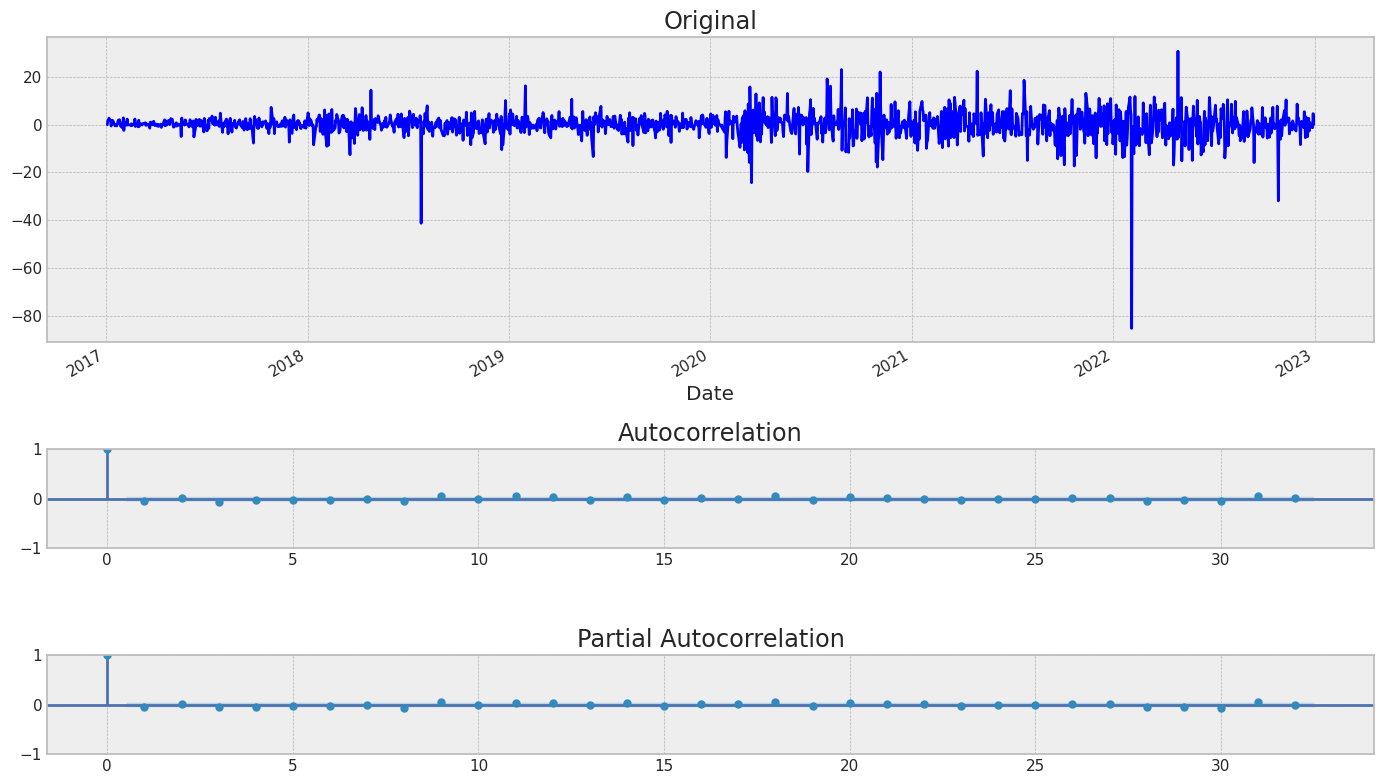

In [24]:
meta_diff = np.diff(meta_df['Close'],1)
meta_df['Close_diff'] = np.append(0,meta_diff)
tsplot(meta_df['Close_diff'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

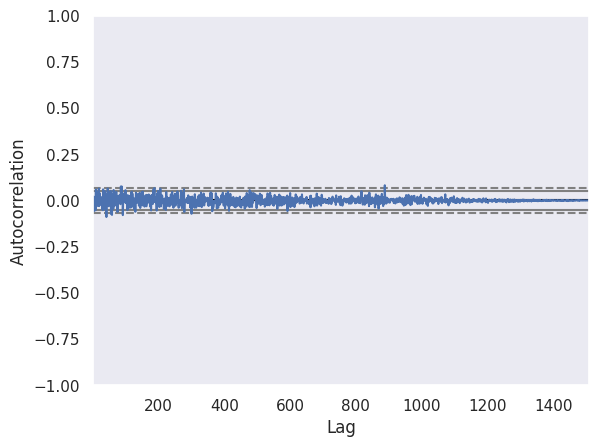

In [25]:
autocorrelation_plot(meta_df['Close_diff'])

# Conclusion

Upon conducting a comprehensive analysis of the time series data for META company stocks, several key observations and conclusions can be drawn.

- ***Price Movement***:
A visual inspection of the price movement reveals a significant decline in stock prices during the period from January 2022 to March 2023.

- ***Trend and Seasonality***:
The price data exhibits discernible trends and some level of seasonality. Additionally, the distribution of prices appears to deviate from normality, as evidenced by the histogram and statistical tests.

- ***Autocorrelation Analysis***:
Autocorrelation analysis indicates notable peaks at each lag, suggesting the presence of seasonality in the data. These observations collectively point towards non-stationarity in the time series.

- ***Stationarity Tests***:
Stationarity tests, including the Dickey-Fuller test, confirm the non-stationary nature of the time series. Furthermore, the seasonal decomposition of the data into trend, seasonal, and residual components visually reinforces the non-stationary characteristics.

- ***Transformation Attempts***:
Attempts were made to make the time series stationary through logarithmic and Box-Cox transformations. However, these transformations did not yield significant improvements.

- ***Difference Transformation***:
The difference transformation (diff) was applied, and at the first differentiation, a noticeable removal of trend was observed. Subsequent statistical tests confirmed the achievement of stationarity in the differenced series.

- ***Future Considerations***:
In summary, the analysis provides valuable insights into the behavior of META stock prices, emphasizing the importance of addressing non-stationarity for meaningful time series analysis and modeling.

# AAPL analysis

In [26]:
aapl_df = get_price_data(ticker='AAPL')

In [27]:
aapl_df.head()

Open       High        Low      Close  \
Date                                                                    
2017-01-03 00:00:00-05:00  26.977774  27.101247  26.735486  27.059313   
2017-01-04 00:00:00-05:00  26.989416  27.143176  26.966120  27.029020   
2017-01-05 00:00:00-05:00  27.005724  27.224716  26.980098  27.166473   
2017-01-06 00:00:00-05:00  27.206078  27.527576  27.133858  27.469334   
2017-01-09 00:00:00-05:00  27.478648  27.823443  27.476320  27.720936   

                              Volume  
Date                                  
2017-01-03 00:00:00-05:00  115127600  
2017-01-04 00:00:00-05:00   84472400  
2017-01-05 00:00:00-05:00   88774400  
2017-01-06 00:00:00-05:00  127007600  
2017-01-09 00:00:00-05:00  134247600

In [28]:
aapl_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

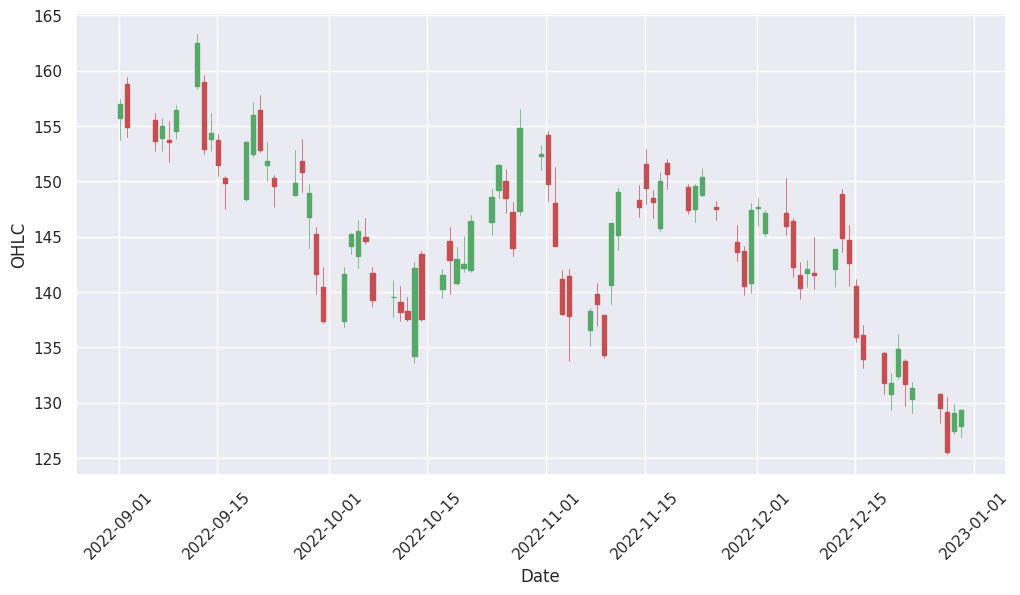

In [29]:
fig = plt.figure(figsize=(12,6))
plot_candlestick(aapl_df['2022-9-1':'2023-1-1'], fig.subplots())
plt.show()

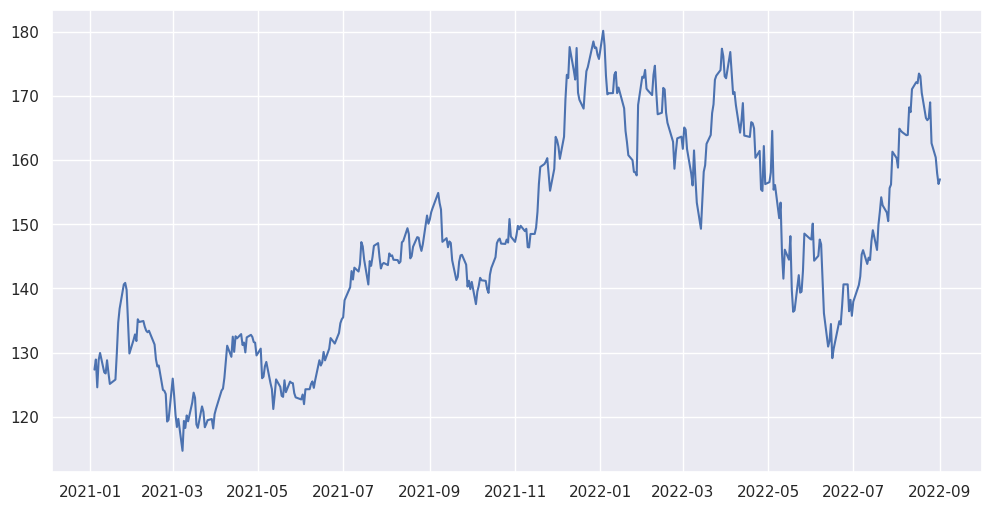

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(aapl_df['2021-1-1':'2022-9-1']['Close'])
plt.show()

In [31]:
aapl_df['Close'].hvplot.line(title="NFLX daily close price 2017-2023", width=1300, height=600, by=['index.year'])

:NdOverlay   [index.year]
   :Curve   [Date]   (Close)

<Axes: xlabel='Close', ylabel='Count'>

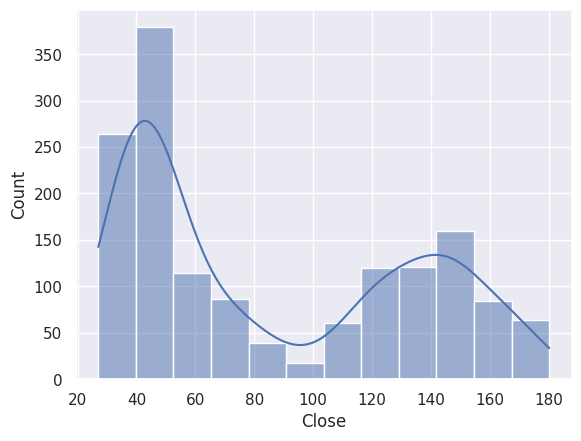

In [32]:
sns.histplot(aapl_df,x='Close',kde=True)

In [33]:
print(is_normal(shapiro(aapl_df['Close'])))
print(is_normal(kstest_normal(aapl_df['Close'])))

Not Normal
Not Normal


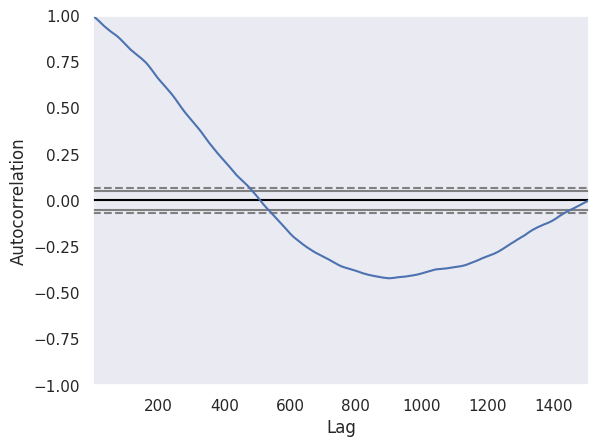

In [34]:
autocorrelation_plot(aapl_df['Close'])
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -0.991705
p-value                           0.756278
#Lags Used                       11.000000
Number of Observations Used    1498.000000
Critical Value (1%)              -3.434723
Critical Value (5%)              -2.863471
Critical Value (10%)             -2.567798
dtype: float64
Results of KPSS Test:
Test Statistic            5.50636
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


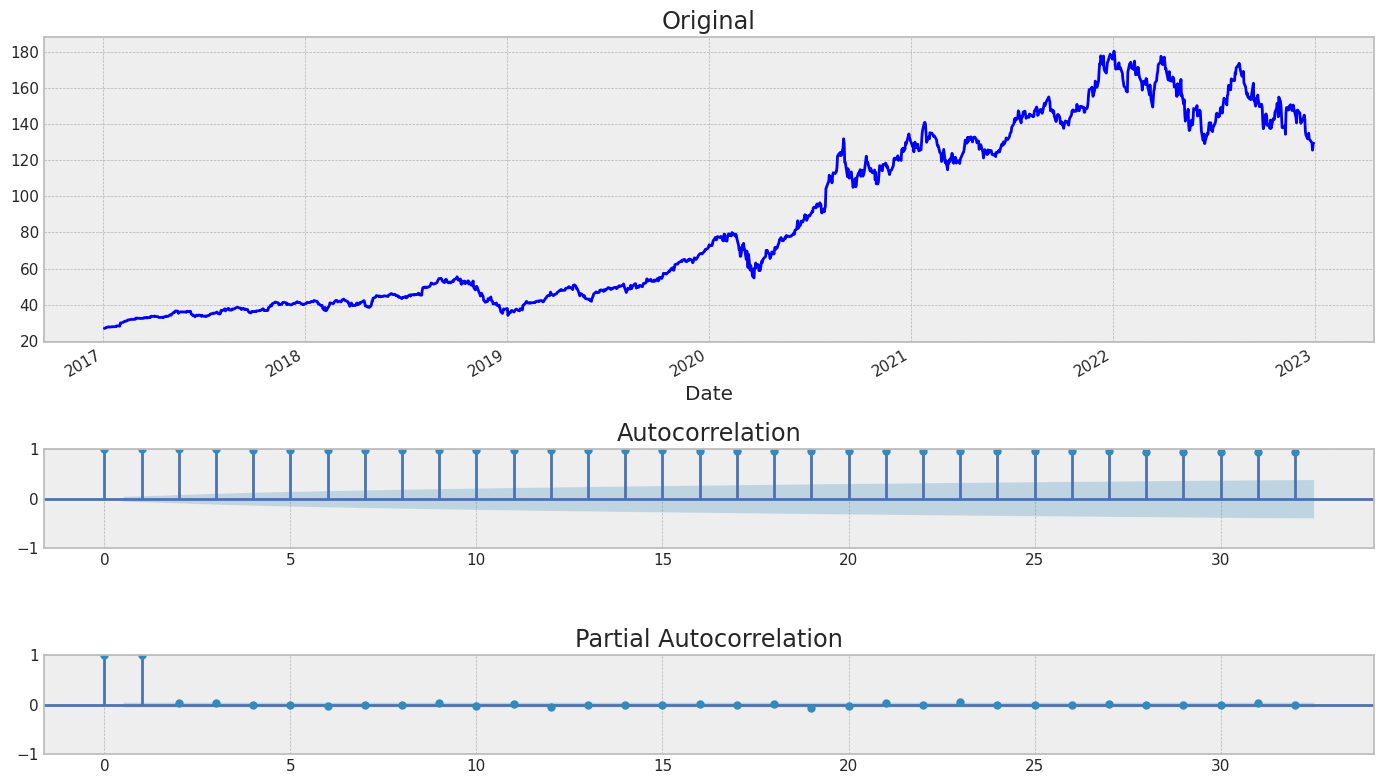

In [35]:
tsplot(aapl_df['Close'])

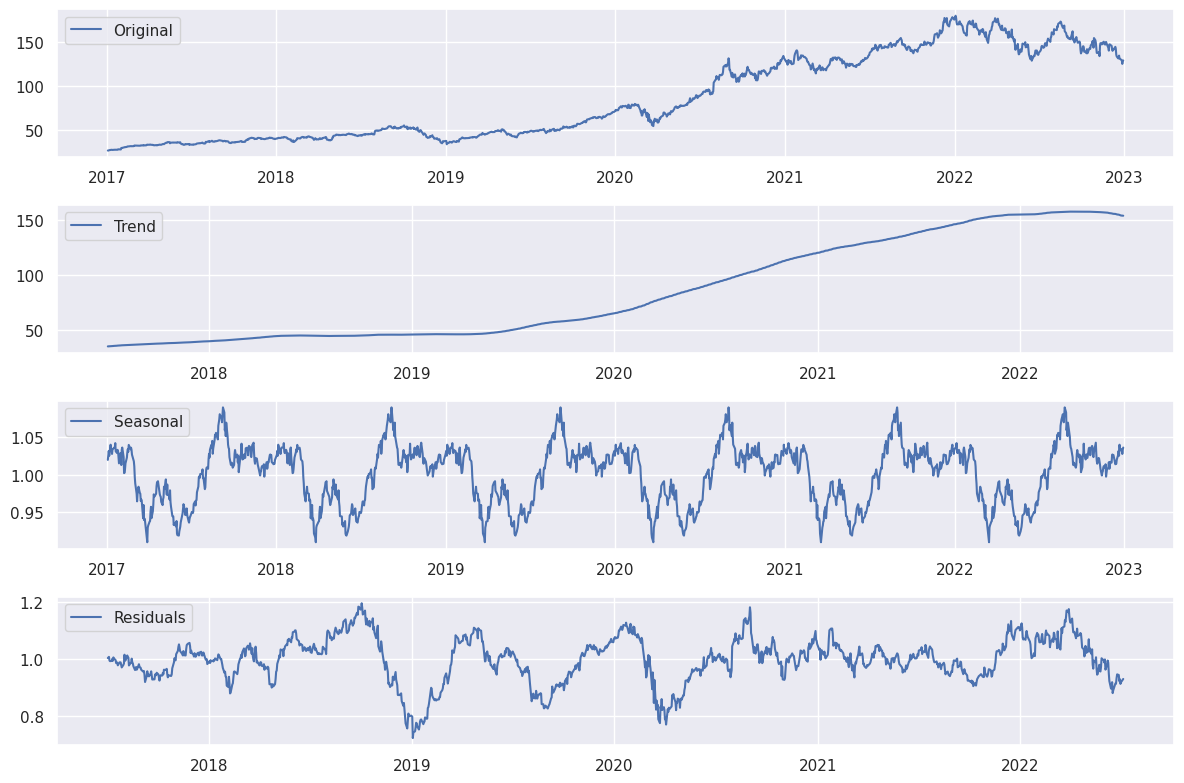

In [36]:
series_decompose(aapl_df['Close'],period=250)

# Make stationarity

Results of Dickey-Fuller Test:
Test Statistic                   -0.991705
p-value                           0.756278
#Lags Used                       11.000000
Number of Observations Used    1498.000000
Critical Value (1%)              -3.434723
Critical Value (5%)              -2.863471
Critical Value (10%)             -2.567798
dtype: float64
Results of KPSS Test:
Test Statistic            5.50636
p-value                   0.01000
#Lags Used               25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


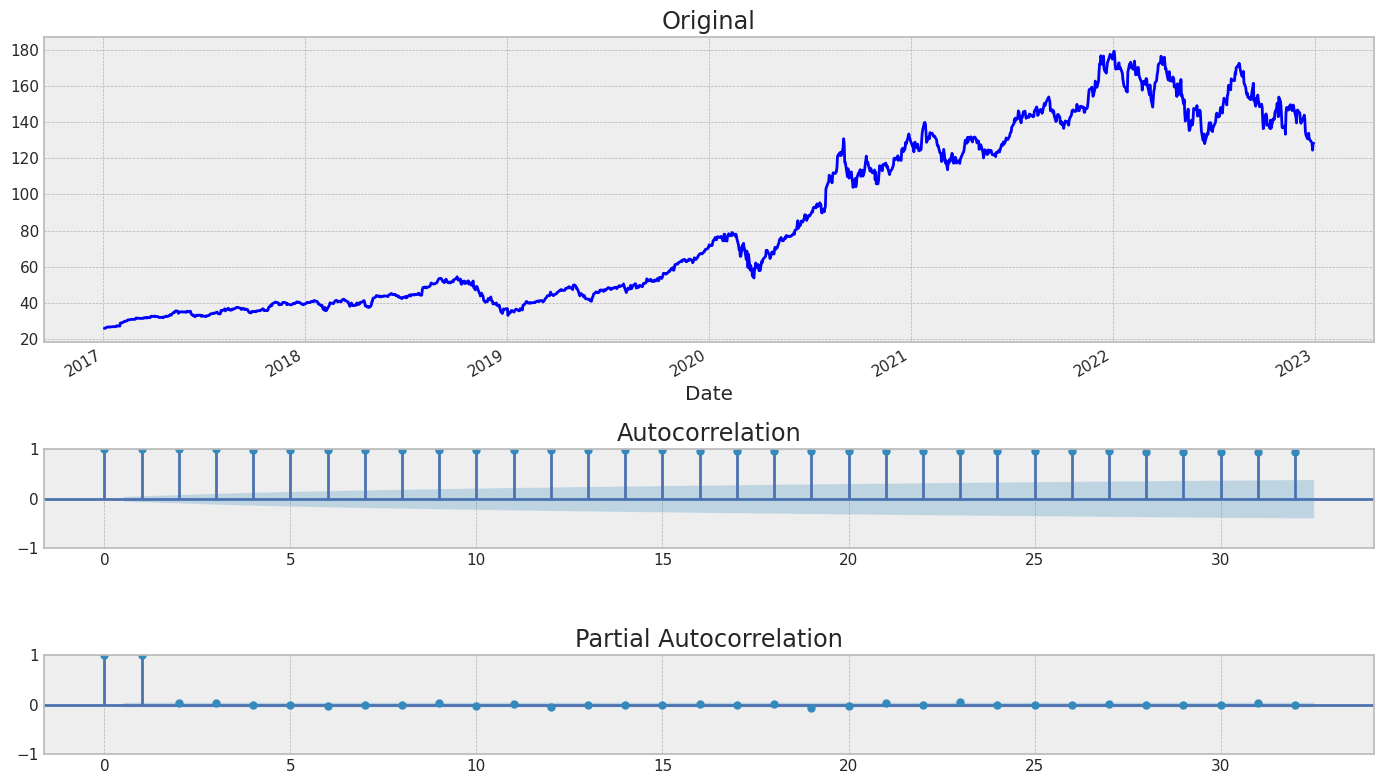

In [37]:
aapl_df['Close_boxcox'] = boxcox(aapl_df['Close'], 1)
tsplot(aapl_df['Close_boxcox'])

Results of Dickey-Fuller Test:
Test Statistic                   -1.352092
p-value                           0.605016
#Lags Used                        9.000000
Number of Observations Used    1500.000000
Critical Value (1%)              -3.434717
Critical Value (5%)              -2.863469
Critical Value (10%)             -2.567797
dtype: float64
Results of KPSS Test:
Test Statistic            5.696443
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


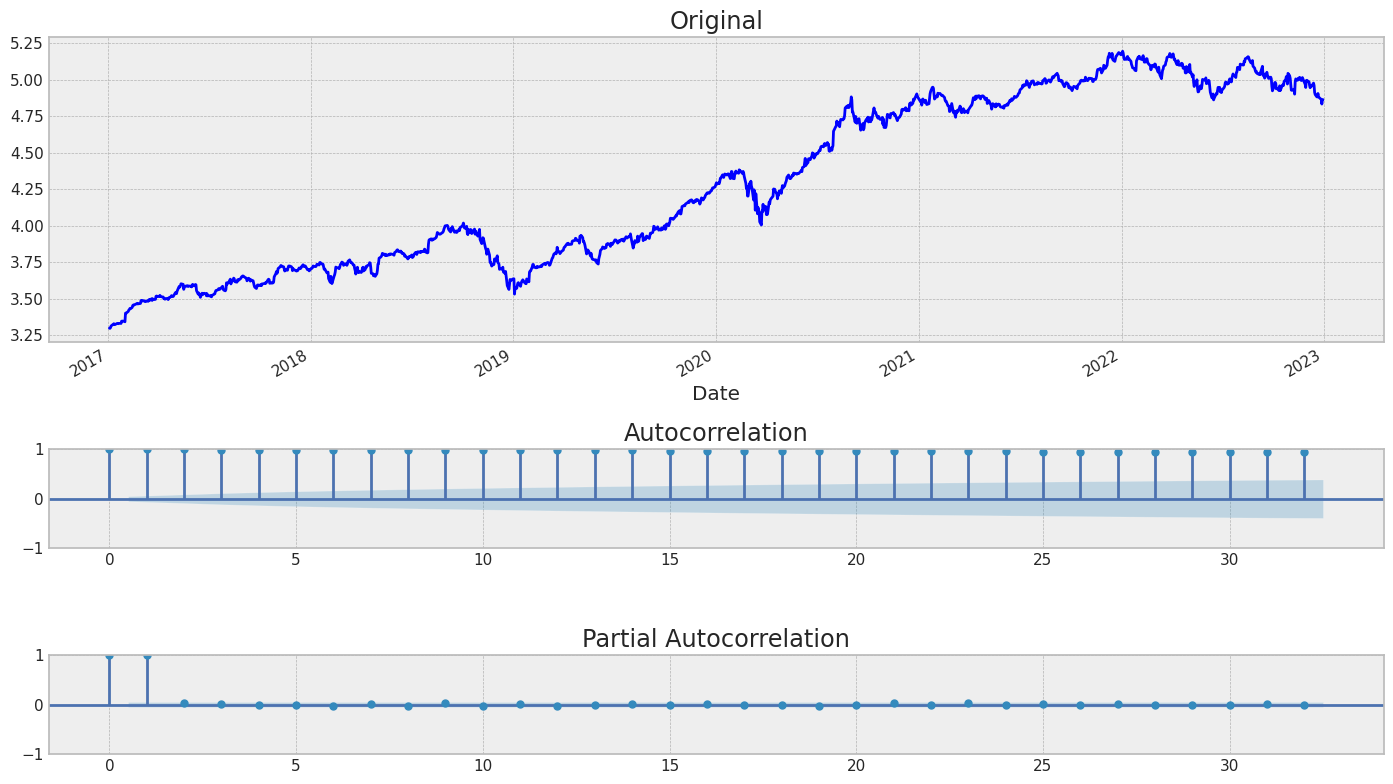

In [38]:
aapl_df['Close_log'] = np.log(aapl_df['Close'])
tsplot(aapl_df['Close_log'])

In [39]:
aapl_df

Open        High         Low       Close  \
Date                                                                        
2017-01-03 00:00:00-05:00   26.977774   27.101247   26.735486   27.059313   
2017-01-04 00:00:00-05:00   26.989416   27.143176   26.966120   27.029020   
2017-01-05 00:00:00-05:00   27.005724   27.224716   26.980098   27.166473   
2017-01-06 00:00:00-05:00   27.206078   27.527576   27.133858   27.469334   
2017-01-09 00:00:00-05:00   27.478648   27.823443   27.476320   27.720936   
...                               ...         ...         ...         ...   
2022-12-23 00:00:00-05:00  130.363811  131.857438  129.089250  131.299820   
2022-12-27 00:00:00-05:00  130.821856  130.851727  128.173153  129.477585   
2022-12-28 00:00:00-05:00  129.119115  130.473338  125.335264  125.504539   
2022-12-29 00:00:00-05:00  127.446252  129.925671  127.187362  129.059372   
2022-12-30 00:00:00-05:00  127.864474  129.397925  126.888634  129.378006   

                              Volume  Close_boxcox  Close_log  
Date                                                           
2017-01-03 00:00:00-05:00  115127600     26.059313   3.298031  
2017-01-04 00:00:00-05:00   84472400     26.029020   3.296911  
2017-01-05 00:00:00-05:00   88774400     26.166473   3.301984  
2017-01-06 00:00:00-05:00  127007600     26.469334   3.313070  
2017-01-09 00:00:00-05:00  134247600     26.720936   3.322188  
...                              ...           ...        ...  
2022-12-23 00:00:00-05:00   63814900    130.299820   4.877483  
2022-12-27 00:00:00-05:00   69007800    128.477585   4.863508  
2022-12-28 00:00:00-05:00   85438400    124.504539   4.832342  
2022-12-29 00:00:00-05:00   75703700    128.059372   4.860273  
2022-12-30 00:00:00-05:00   77034200    128.378006   4.862738  

[1510 rows x 7 columns]

Results of Dickey-Fuller Test:
Test Statistic                -1.147901e+01
p-value                        5.048156e-21
#Lags Used                     1.000000e+01
Number of Observations Used    1.499000e+03
Critical Value (1%)           -3.434720e+00
Critical Value (5%)           -2.863470e+00
Critical Value (10%)          -2.567798e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.113157
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


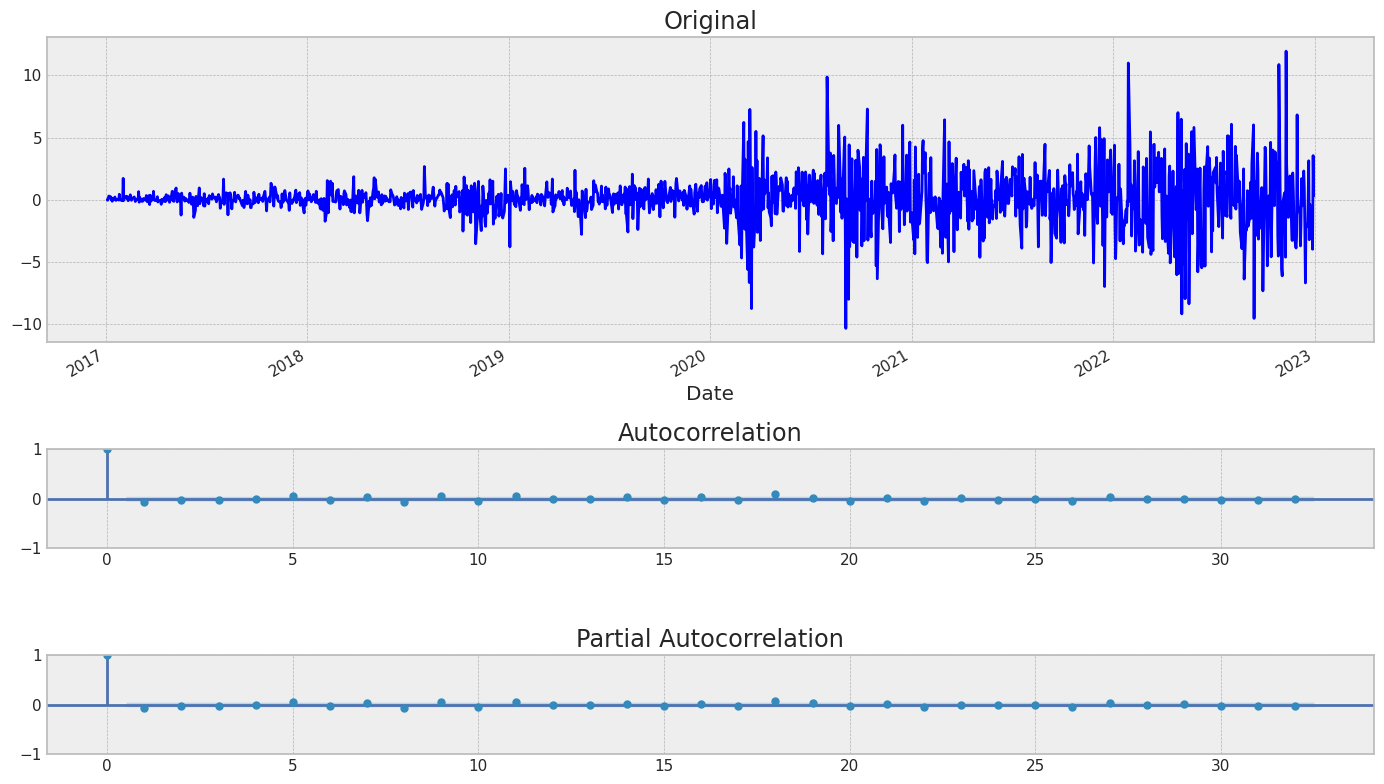

In [40]:
aapld_dif = np.diff(aapl_df['Close'],1)
aapl_df['Close_diff'] = np.append(0,aapld_dif)
tsplot(aapl_df['Close_diff'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

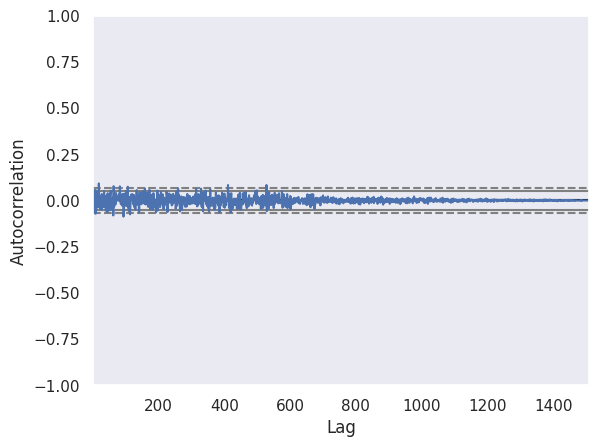

In [41]:
autocorrelation_plot(aapl_df['Close_diff'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.734441
p-value                          0.068266
#Lags Used                      14.000000
Number of Observations Used    787.000000
Critical Value (1%)             -3.438686
Critical Value (5%)             -2.865219
Critical Value (10%)            -2.568729
dtype: float64
Results of KPSS Test:
Test Statistic            4.274797
p-value                   0.010000
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


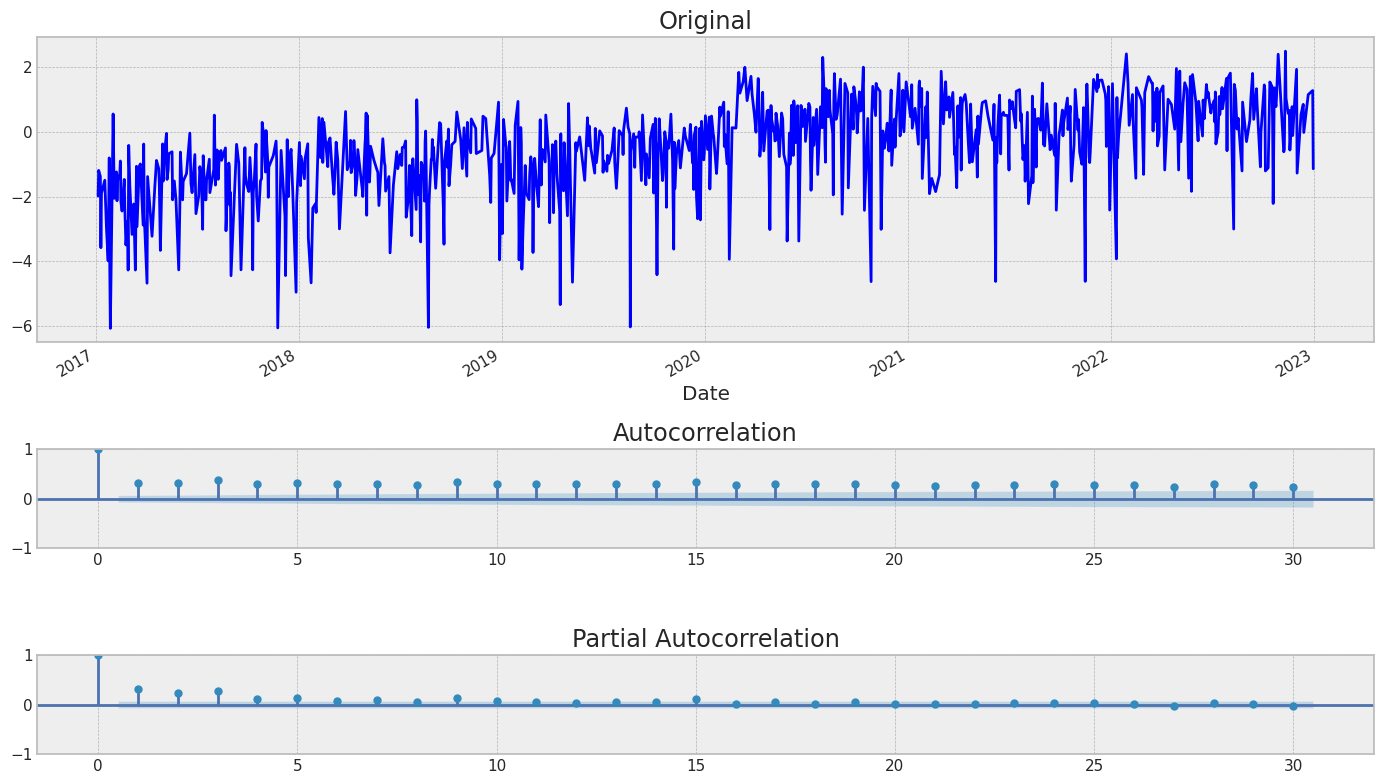

In [42]:
nflx_log = np.log(aapl_df['Close_diff']).replace([np.inf, -np.inf], np.nan).dropna()
tsplot(nflx_log)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

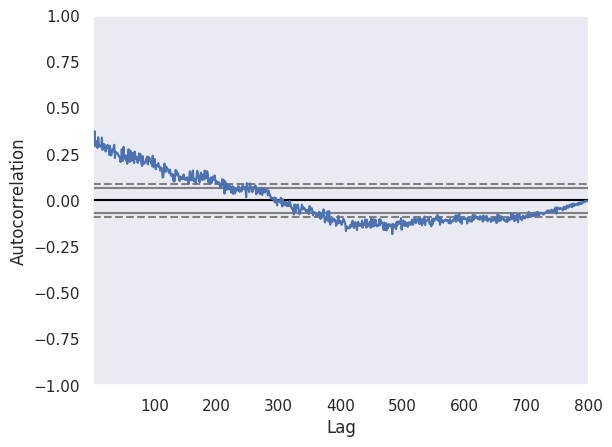

In [43]:
autocorrelation_plot(nflx_log)

## Conclusion for APL Stocks

Upon analyzing the time series data for APL company stocks, distinct patterns emerge, highlighting key characteristics that differ from the META stocks.

- ***Price Movement***:
Contrary to META stocks, there is no observable sharp decline in APL stock prices. Instead, the prices exhibit a steady and uniform increase over time.

- ***Trend and Seasonality***:
Similar to META, APL stocks display noticeable trends and seasonality. Both these aspects introduce complexities that need to be addressed during further analysis.

- ***Distribution Analysis***:
The examination of the target variable's distribution reveals a non-normal distribution, a finding corroborated by statistical tests.

- ***Autocorrelation Analysis***:
Autocorrelation analysis suggests the presence of seasonality in APL stock prices, indicating a recurring pattern over specific lags.

- ***Seasonal Decomposition***:
Further investigation through seasonal decomposition unveils clear seasonality, trend, and cyclic components in the data. Dickey-Fuller test results align with these observations, affirming the non-stationary nature of the time series.

- ***Transformation Attempts***:
Efforts to induce stationarity through Box-Cox and logarithmic transformations did not yield significant improvements. However, the first-order differencing was effective in removing the trend.


# AAPL and META analysis

In [44]:
scaler = StandardScaler()
df = pd.DataFrame()

In [45]:
df['aapl_df'] = aapl_df['Close']
df['meta_df'] = meta_df['Close']

In [46]:
df[['aapl_df','meta_df']] = scaler.fit_transform(df)

In [47]:
(df['meta_df'].hvplot(width=800, height=500) *
df['aapl_df'].hvplot())

:Overlay
   .Curve.Meta_df :Curve   [Date]   (meta_df)
   .Curve.Aapl_df :Curve   [Date]   (aapl_df)

In [48]:
(df['aapl_df'].hvplot.line(width=800,height=500,by=['index.year'])+
 df['meta_df'].hvplot.line(width=800,height=500,by=['index.year']))

:Layout
   .NdOverlay.Aapl_df :NdOverlay   [index.year]
      :Curve   [Date]   (aapl_df)
   .NdOverlay.Meta_df :NdOverlay   [index.year]
      :Curve   [Date]   (meta_df)

# Building model for AAPL

### PHOPHET

In [52]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates the mean absolute percentage error (MAPE) between true and predicted values.

    Parameters:
    - y_true (array-like): Array or Pandas Series of true values.
    - y_pred (array-like): Array or Pandas Series of predicted values.

    Returns:
    - mape (float): Mean absolute percentage error.

    Example Usage:

    # Assuming 'true_values' and 'predicted_values' are arrays or Pandas Series
    mape_value = mean_absolute_percentage_error(true_values, predicted_values)
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [53]:
def df_formatting(df):
    """
    Formats a DataFrame for use in time series forecasting models.

    Parameters:
    - df (DataFrame): Input DataFrame containing time series data.

    Returns:
    - df_formatted (DataFrame): Formatted DataFrame with columns 'ds' (datetime) and 'y' (target variable).

    Example Usage:

    # Assuming 'my_dataframe' is a DataFrame with a 'Close' column and datetime index
    formatted_data = df_formatting(my_dataframe)
    """
    df = df['Close'].reset_index()
    df.columns  = ['ds','y']
    df['ds'] = df['ds'].dt.tz_localize(None)
    
    return df

In [54]:
def train_prophet(df,ntest = False):
    """
    Trains a Prophet time series forecasting model on the provided DataFrame.

    Parameters:
    - df (DataFrame): Formatted DataFrame with columns 'ds' (datetime) and 'y' (target variable).
    - ntest (int or False, optional): Number of test data points to exclude from training. Defaults to False.

    Returns:
    - prophet_model (Prophet): Trained Prophet model.

    Example Usage:

    # Assuming 'formatted_data' is a DataFrame formatted with df_formatting function
    trained_prophet_model = train_prophet(formatted_data, ntest=20)
    """
    if not ntest:
        train_df = df
    else:
        train_df = df[:-ntest]
        
    prophet = Prophet(yearly_seasonality=4,
        weekly_seasonality=2,
        daily_seasonality=5,
        seasonality_prior_scale=0.001)
    prophet.add_country_holidays('US')
    prophet.fit(train_df)

    return prophet

In [55]:
def prophet_forecasting(df, model ,ntest = False, period = 30):
    """
    Generates forecasts using a trained Prophet model and evaluates performance if test data is provided.

    Parameters:
    - df (DataFrame): Formatted DataFrame with columns 'ds' (datetime) and 'y' (target variable).
    - model (Prophet): Trained Prophet model.
    - ntest (int or False, optional): Number of test data points to evaluate model performance. Defaults to False.
    - period (int, optional): Number of days to forecast into the future. Defaults to 30.

    Returns:
    - forecast (pd.DataFrame): DataFrame containing the forecasted values.

    Example Usage:

    # Assuming 'formatted_data' is a DataFrame formatted with df_formatting function
    # and 'trained_prophet_model' is a Prophet model trained with train_prophet function
    forecast_data = prophet_forecasting(formatted_data, trained_prophet_model, ntest=20, period=30)
    """

    future_price = model.make_future_dataframe(periods=period,freq='d')
    forecast = model.predict(future_price)
    
    if ntest:
        test_df = df[:-365]
        error = mean_absolute_percentage_error(
            df[len(test_df):len(test_df)+ntest]['y'], 
            forecast[len(test_df):len(test_df)+ntest]['yhat'])
        print("Mean absolute percentage error {0:.2f}%".format(error))
    
    fig = model.plot(forecast)

    fig2 = model.plot_components(forecast)
    
    return forecast

In [56]:
aaplfr_df = df_formatting(aapl_df)

In [57]:
aaplfr_df

ds           y
0    2017-01-03   27.059305
1    2017-01-04   27.029018
2    2017-01-05   27.166473
3    2017-01-06   27.469332
4    2017-01-09   27.720936
...         ...         ...
1505 2022-12-23  131.299820
1506 2022-12-27  129.477585
1507 2022-12-28  125.504547
1508 2022-12-29  129.059372
1509 2022-12-30  129.378006

[1510 rows x 2 columns]

In [58]:
model = train_prophet(aaplfr_df,365)

08:23:22 - cmdstanpy - INFO - Chain [1] start processing
08:23:22 - cmdstanpy - INFO - Chain [1] done processing


### 30 days forecasting

Mean absolute percentage error 5.56%


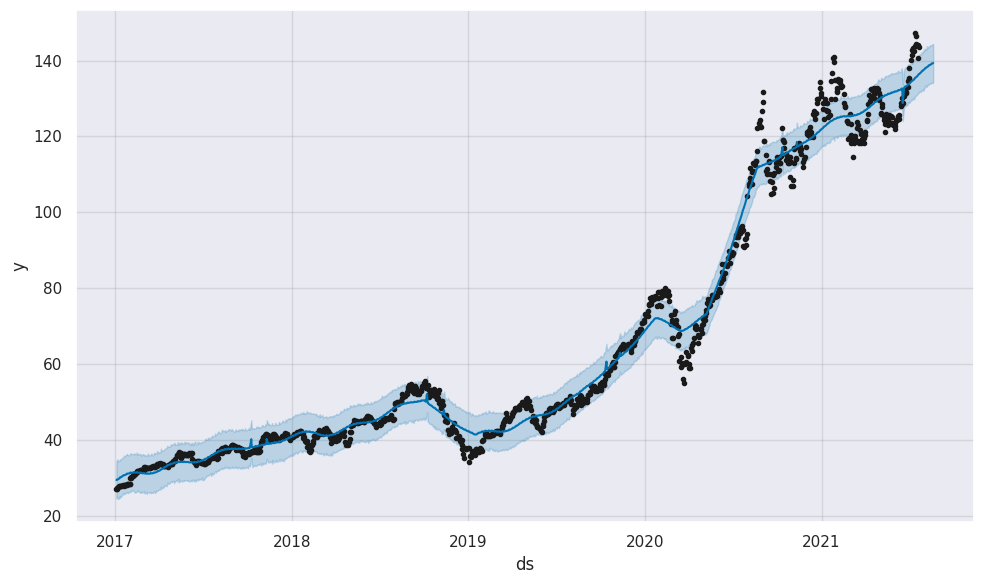

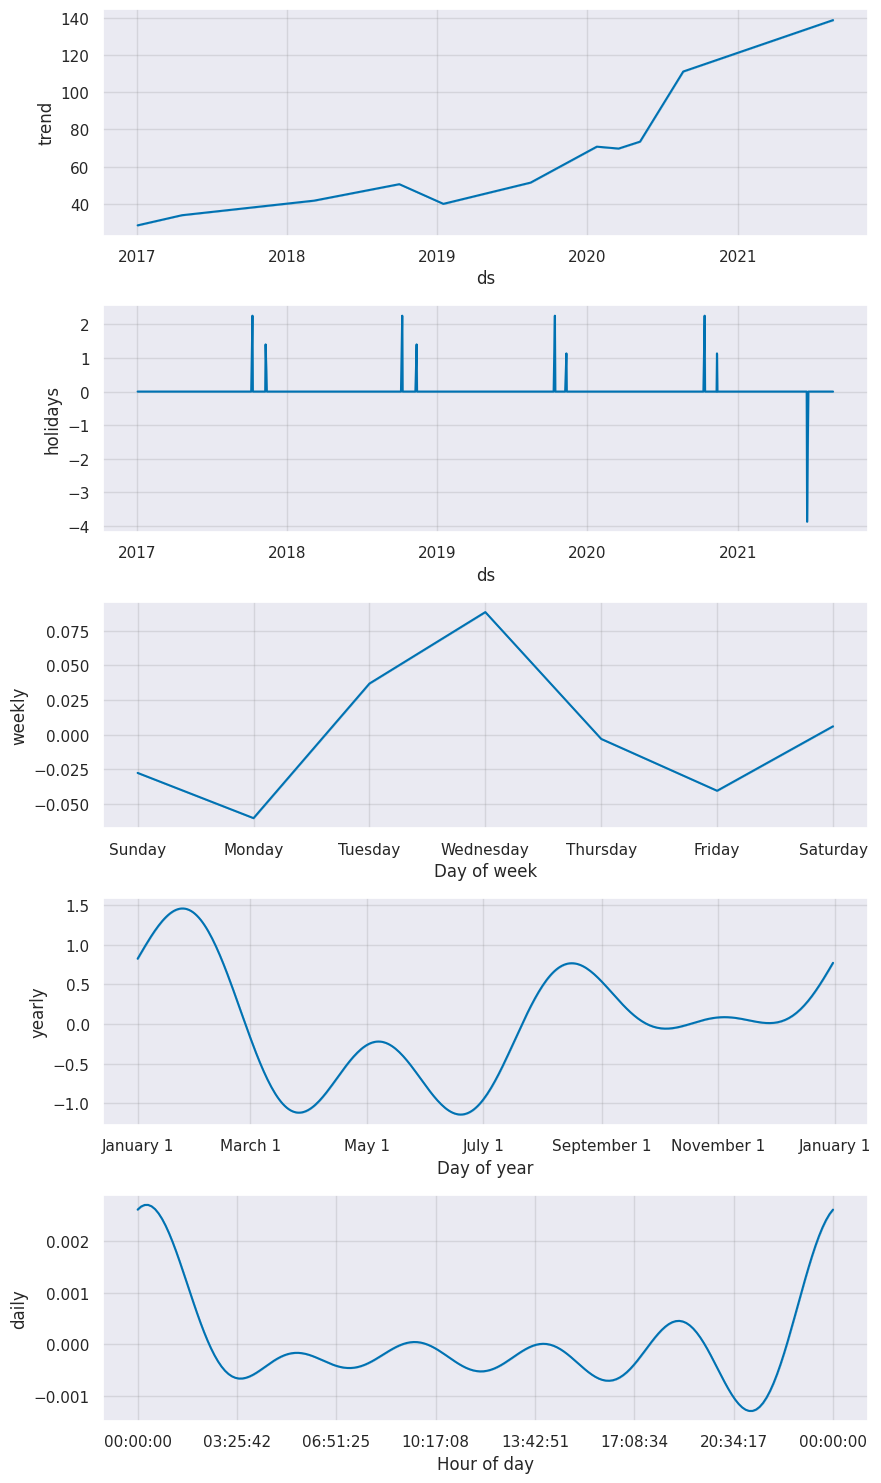

In [59]:
_ = prophet_forecasting(aaplfr_df,model,30,30)

### quarter forecasting

Mean absolute percentage error 4.69%


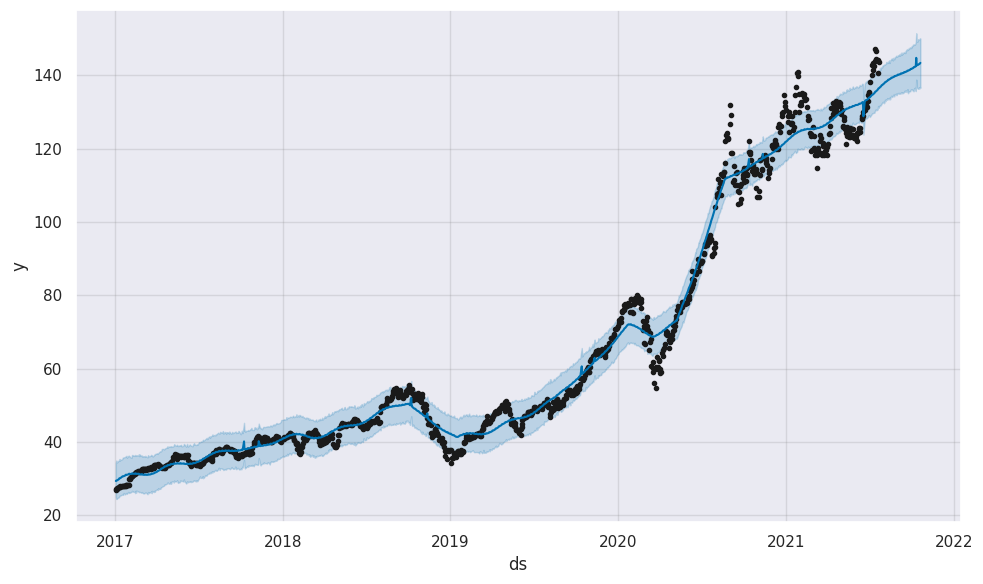

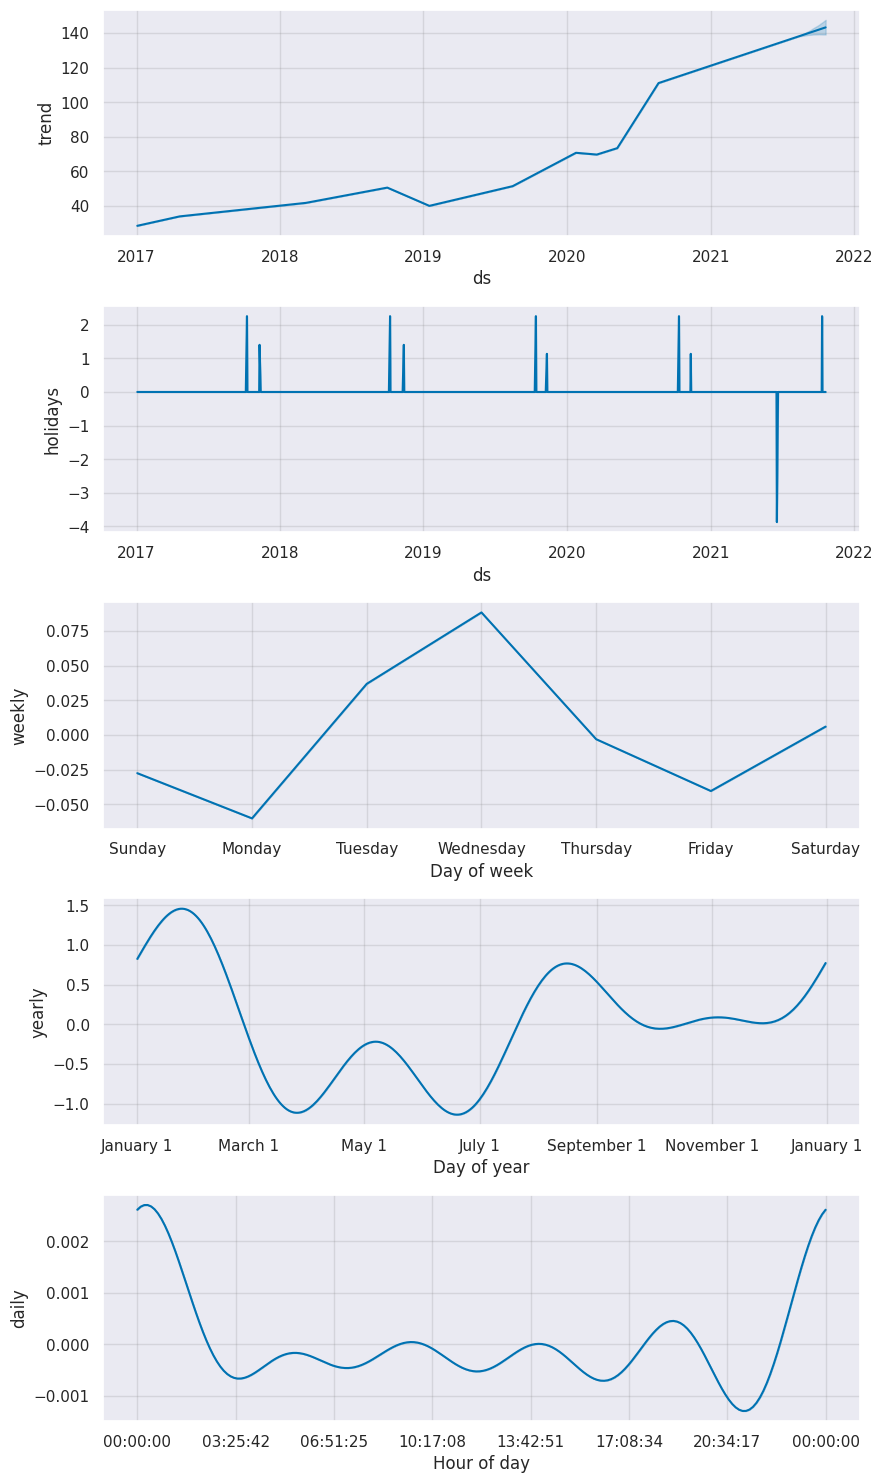

In [60]:
_ = prophet_forecasting(aaplfr_df,model,91,91)

### half-year forecasting

Mean absolute percentage error 8.53%


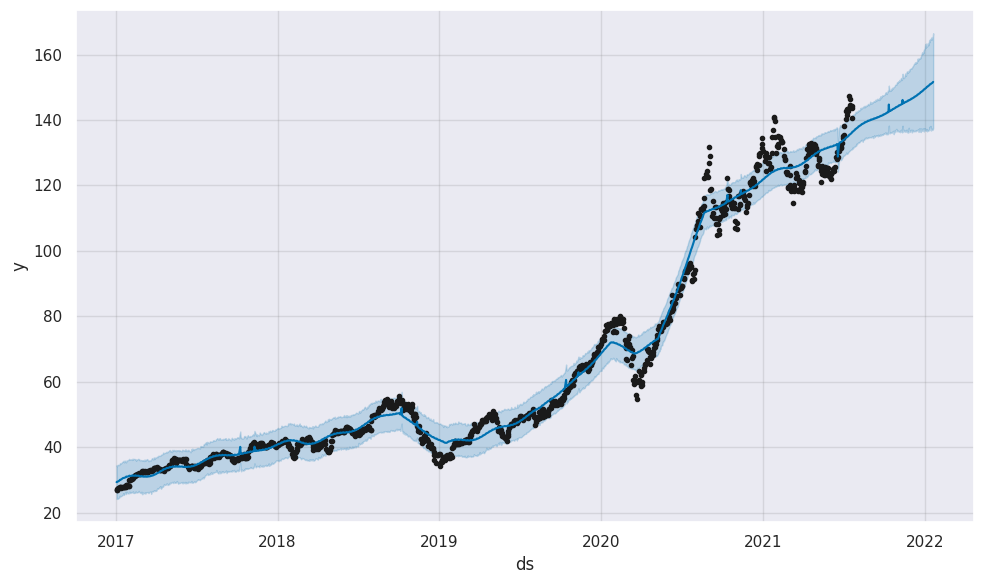

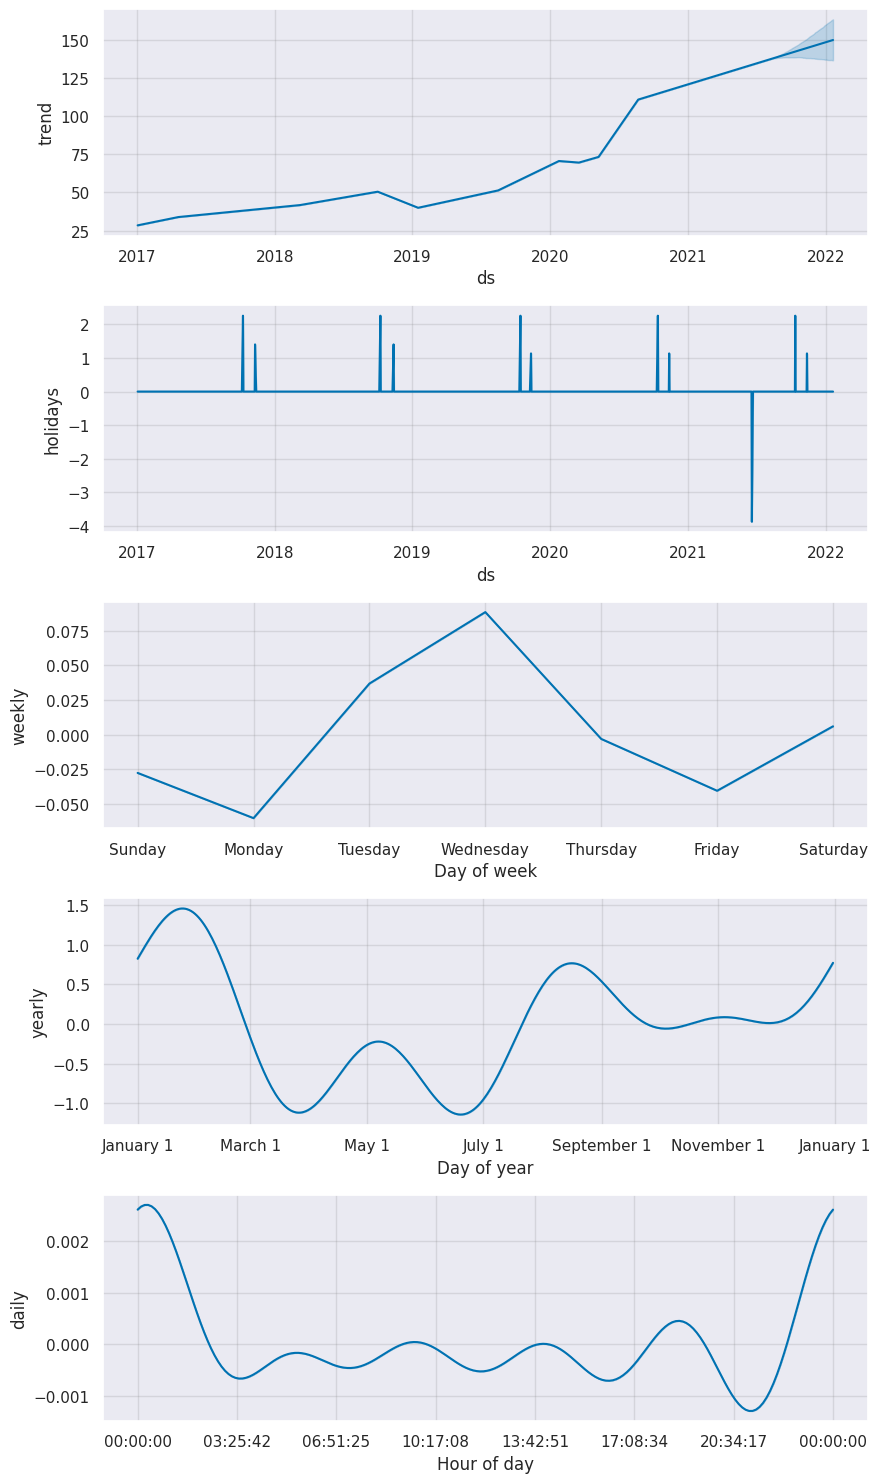

In [61]:
_ = prophet_forecasting(aaplfr_df,model,182,182)

### year forecasting

Mean absolute percentage error 8.61%


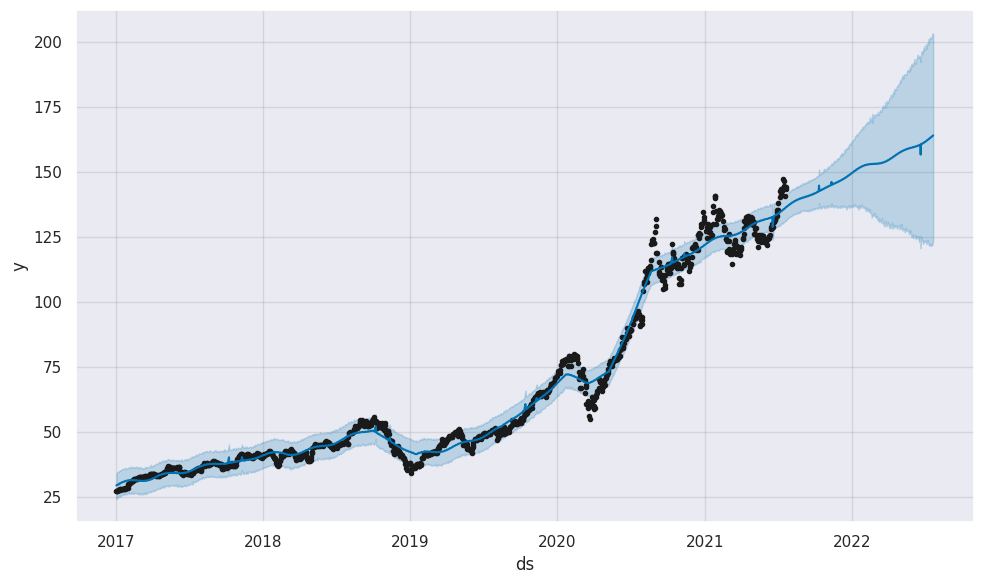

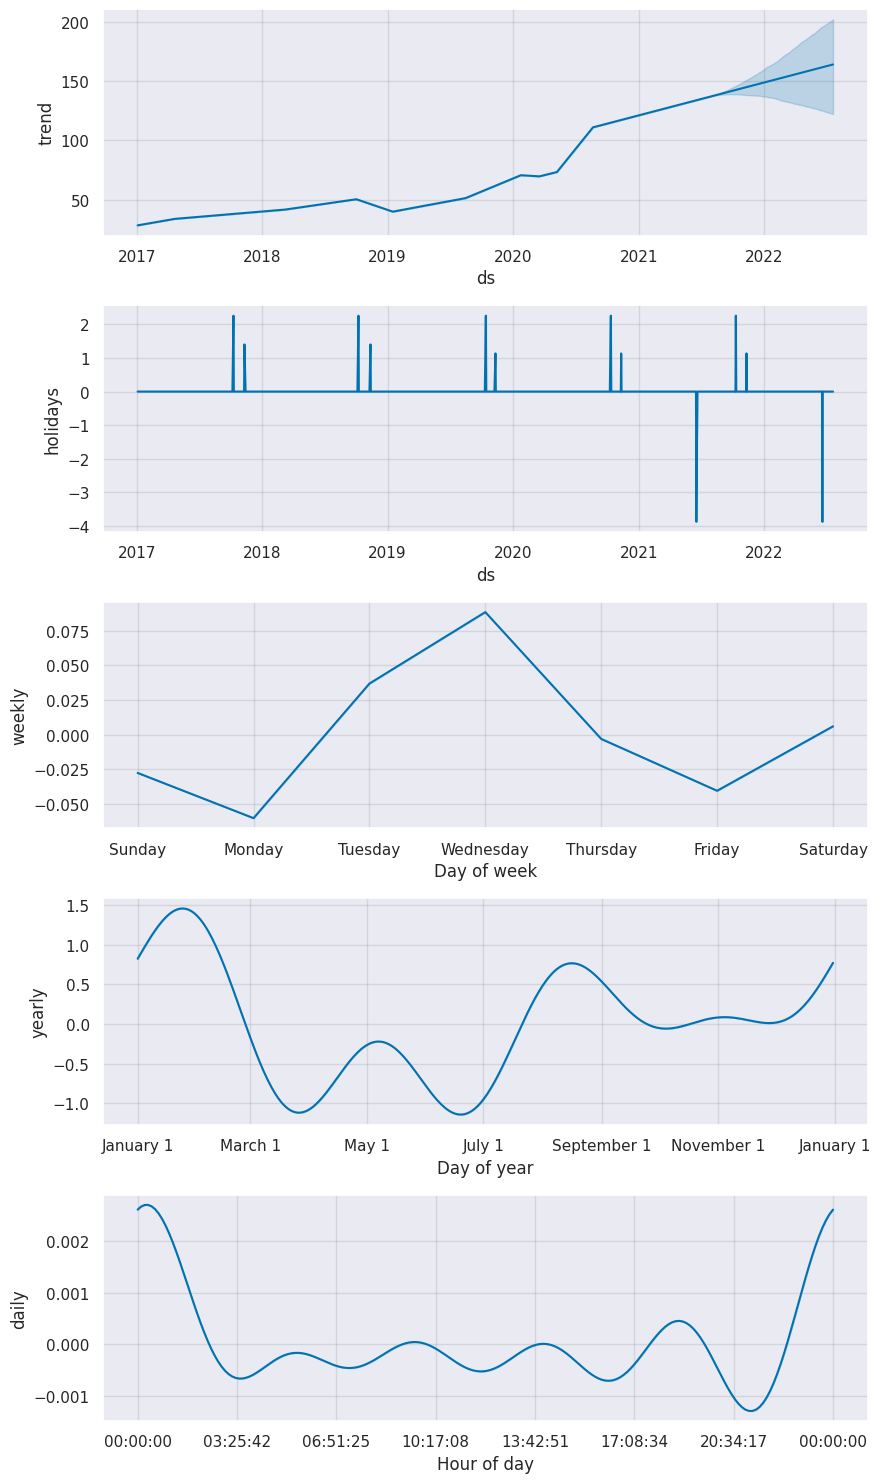

In [62]:
_ = prophet_forecasting(aaplfr_df,model,365,365)

### future 30 days forecasting

In [63]:
model1 = train_prophet(aaplfr_df)

08:23:31 - cmdstanpy - INFO - Chain [1] start processing
08:23:31 - cmdstanpy - INFO - Chain [1] done processing


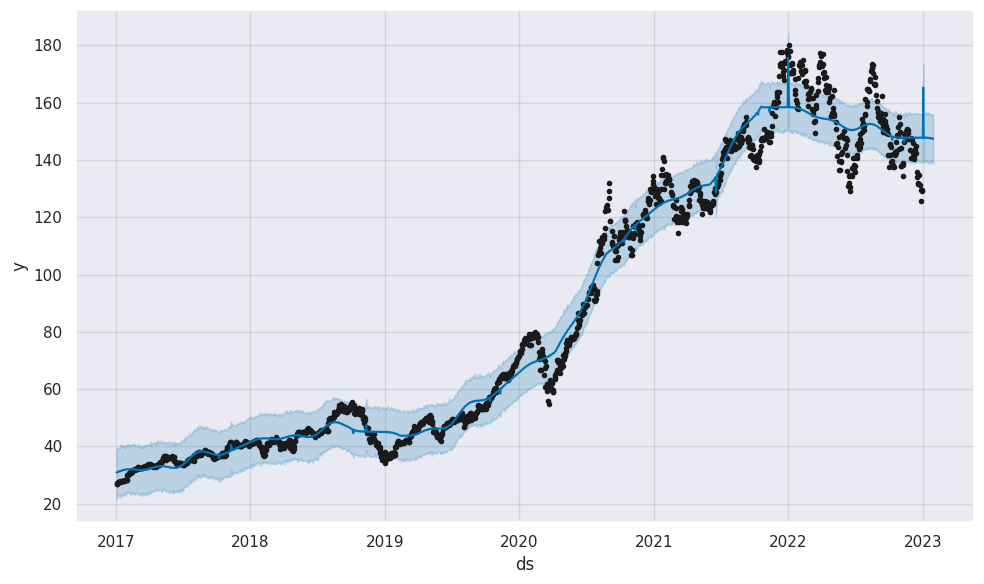

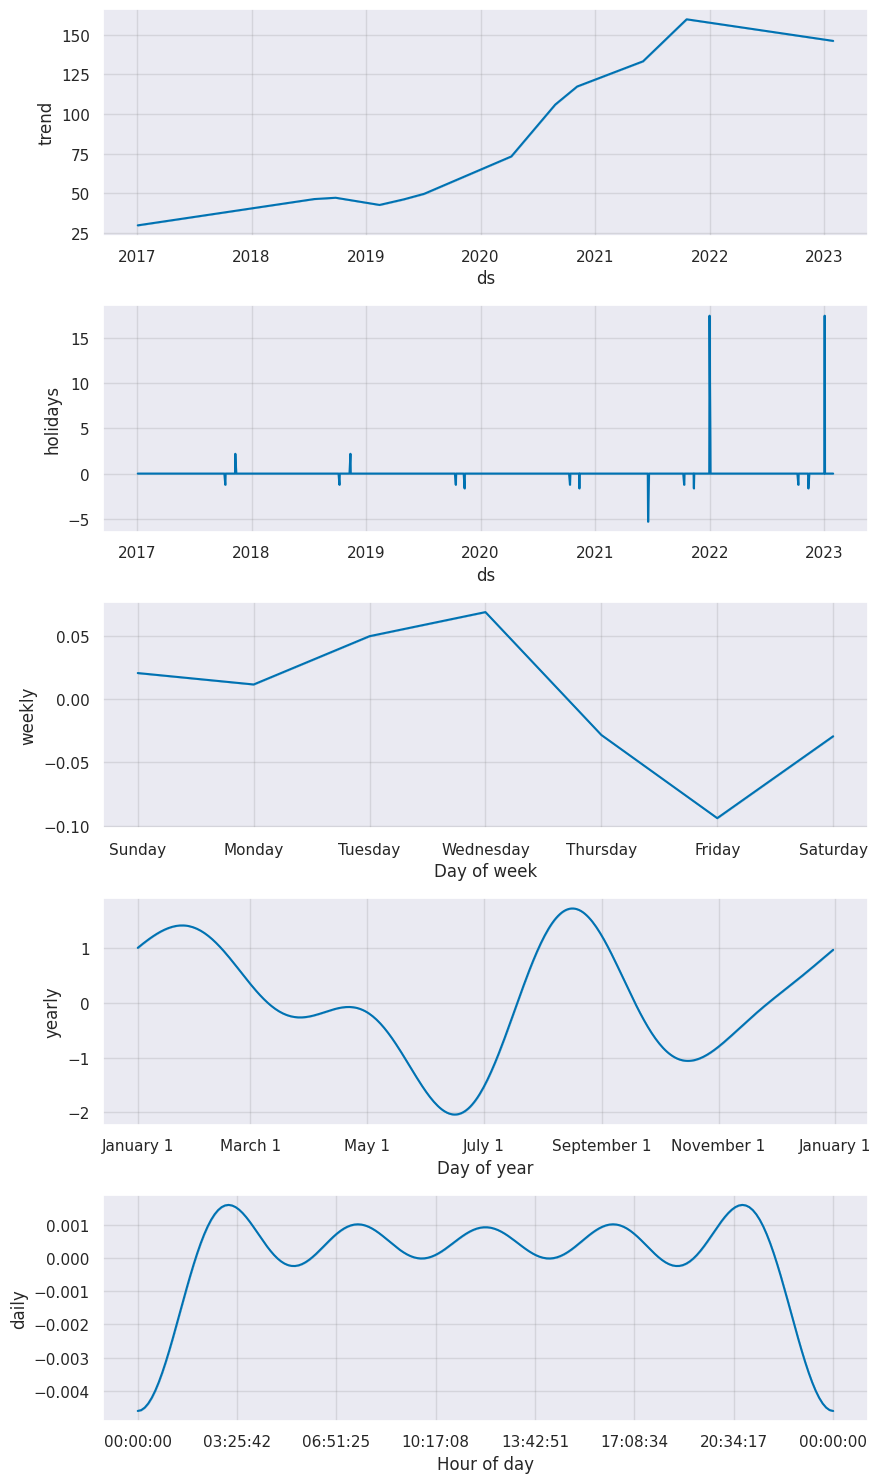

In [64]:
forecast = prophet_forecasting(aaplfr_df,model1,False,30)

Results of Dickey-Fuller Test:
Test Statistic                   -0.596446
p-value                           0.871783
#Lags Used                       20.000000
Number of Observations Used    1519.000000
Critical Value (1%)              -3.434662
Critical Value (5%)              -2.863445
Critical Value (10%)             -2.567784
dtype: float64
Results of KPSS Test:
Test Statistic            5.744727
p-value                   0.010000
#Lags Used               25.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


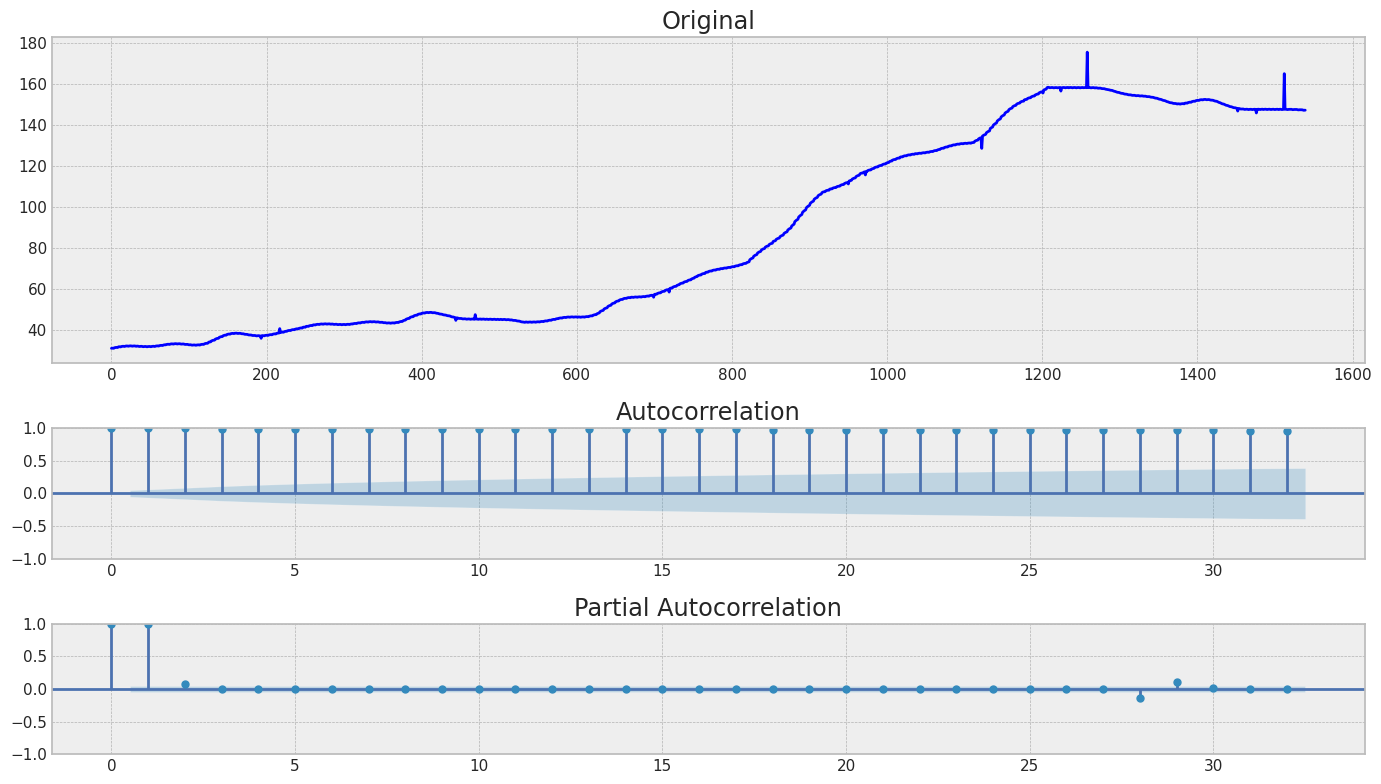

In [65]:
tsplot(forecast['yhat'])

### ARIMA

In [66]:
def arima_split(df,ntest):
    """
    Trains a Prophet time series forecasting model on the provided DataFrame.

    Parameters:
    - df (DataFrame): Formatted DataFrame with columns 'ds' (datetime) and 'y' (target variable).
    - ntest (int or False, optional): Number of test data points to exclude from training. Defaults to False.

    Returns:
    - prophet_model (Prophet): Trained Prophet model.

    Example Usage:

    # Assuming 'formatted_data' is a DataFrame formatted with df_formatting function
    trained_prophet_model = train_prophet(formatted_data, ntest=20)
    """
    train_df = (df['y'])[:-ntest]
    test_df = (df['y'])[-ntest:]
    
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")

    return train_df, test_df

In [67]:
def find_best_fit_arima(df):
    """
    Finds the best-fitting ARIMA model using automated model selection.

    Parameters:
    - df (pd.Series): Time series data for model fitting.

    Returns:
    - model (pm.ARIMA): Auto ARIMA model with the best-fitting parameters.

    Example Usage:

    # Assuming 'my_timeseries' is a Pandas Series
    best_fit_model = find_best_fit_arima(my_timeseries)
    """
    model = pm.auto_arima(df, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 12,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')
    
    return model

In [68]:
def display_model_plots(model):
    """
    Displays diagnostic plots for an ARIMA model.

    Parameters:
    - model (pm.ARIMA): ARIMA model for which diagnostic plots will be displayed.

    Example Usage:

    # Assuming 'my_arima_model' is an ARIMA model fitted using pmdarima
    display_model_plots(my_arima_model)
    """
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle(f'Model diagnostics of AAPL', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')

In [69]:
def arima_forecast(model,test,train,period):
    """
     Generates ARIMA model forecasts, evaluates performance, and plots results.
 
     Parameters:
     - model (pm.ARIMA): Fitted ARIMA model.
     - test (pd.Series): Series representing the test set.
     - train (pd.Series): Series representing the training set.
     - period (int): Number of periods to forecast into the future.
 
     Example Usage:
 
     # Assuming 'my_arima_model' is an ARIMA model fitted using pmdarima
     # 'test_set' is the test set and 'train_set' is the training set
     arima_forecast(my_arima_model, test_set, train_set, period=30)
     """
    train_predictions = model.predict_in_sample(start=len(test), end=-1)
    test_predictions, confidence_interval = model.predict(n_periods=period, return_conf_int=True)
    
    error = mean_absolute_percentage_error(test,test_predictions)
    print("Mean absolute percentage error {0:.2f}%".format(error))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(aaplfr_df.index, aaplfr_df['y'], label='data')
    ax.plot(train.index[len(test):], train_predictions, label='fitted')
    ax.plot(test_predictions.index, test_predictions, label='forecast')
    ax.fill_between(test_predictions.index, confidence_interval[:,0], confidence_interval[:, 1], color='red', alpha=0.3)
    ax.legend();


### 30 days forecasting

In [70]:
apl_train, apl_test = arima_split(aaplfr_df,30)

Train Size: 1480, Test Size: 30


In [71]:
model_apl = find_best_fit_arima(apl_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9573.750, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=6735.935, Time=2.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=8364.906, Time=1.98 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9604.564, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7136.031, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=6570.992, Time=6.49 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=13.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=6.69 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=9573.677, Time=3.94 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=6569.353, Time=8.16 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=6734.265, Time=2.83 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=23.85 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=13.26 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AI

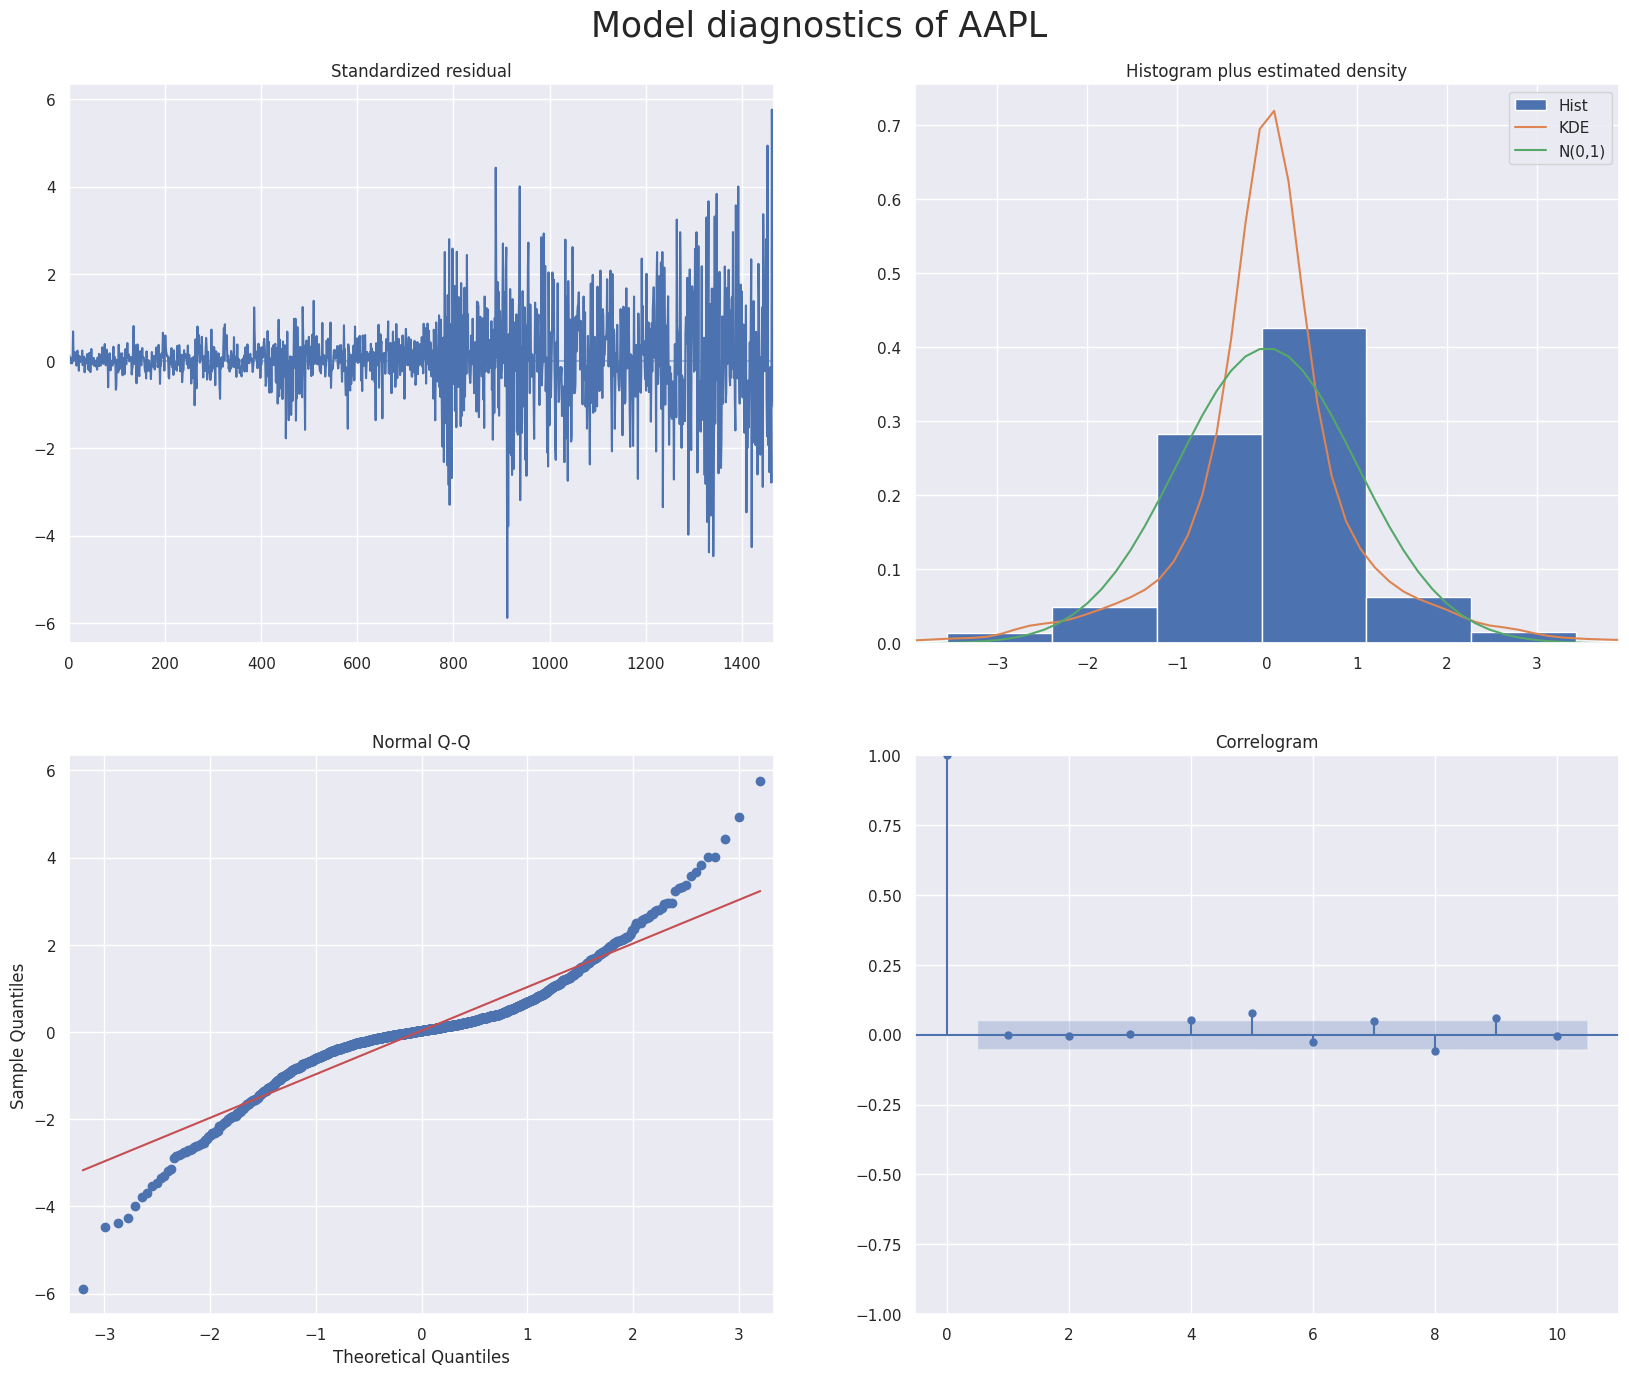

In [72]:
display_model_plots(model_apl)

Mean absolute percentage error 5.26%


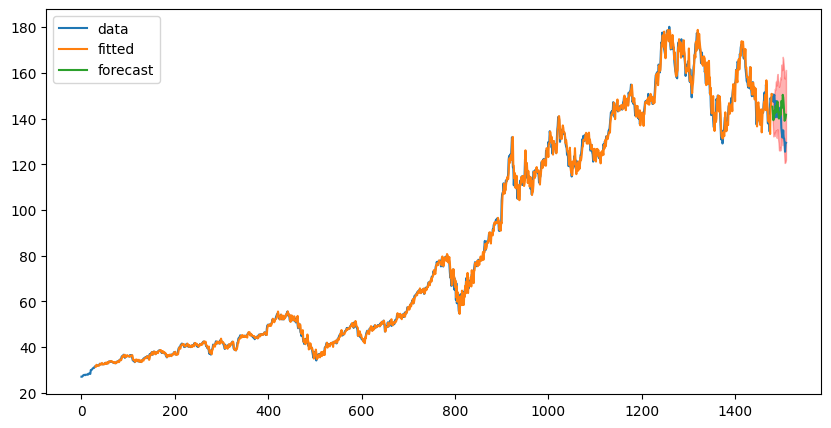

In [73]:
arima_forecast(model_apl,apl_test,apl_train,30)

### quarter forecasting

In [74]:
apl_train, apl_test = arima_split(aaplfr_df,91)

Train Size: 1419, Test Size: 91


In [75]:
model_apl1 = find_best_fit_arima(apl_train)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.76 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=9073.856, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=6305.458, Time=1.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=7910.526, Time=1.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9126.158, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=6687.468, Time=0.17 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=6134.953, Time=4.30 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=14.09 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.63 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=9073.088, Time=3.21 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=6134.447, Time=6.46 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=6304.478, Time=2.69 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=14.29 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=7.68 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC

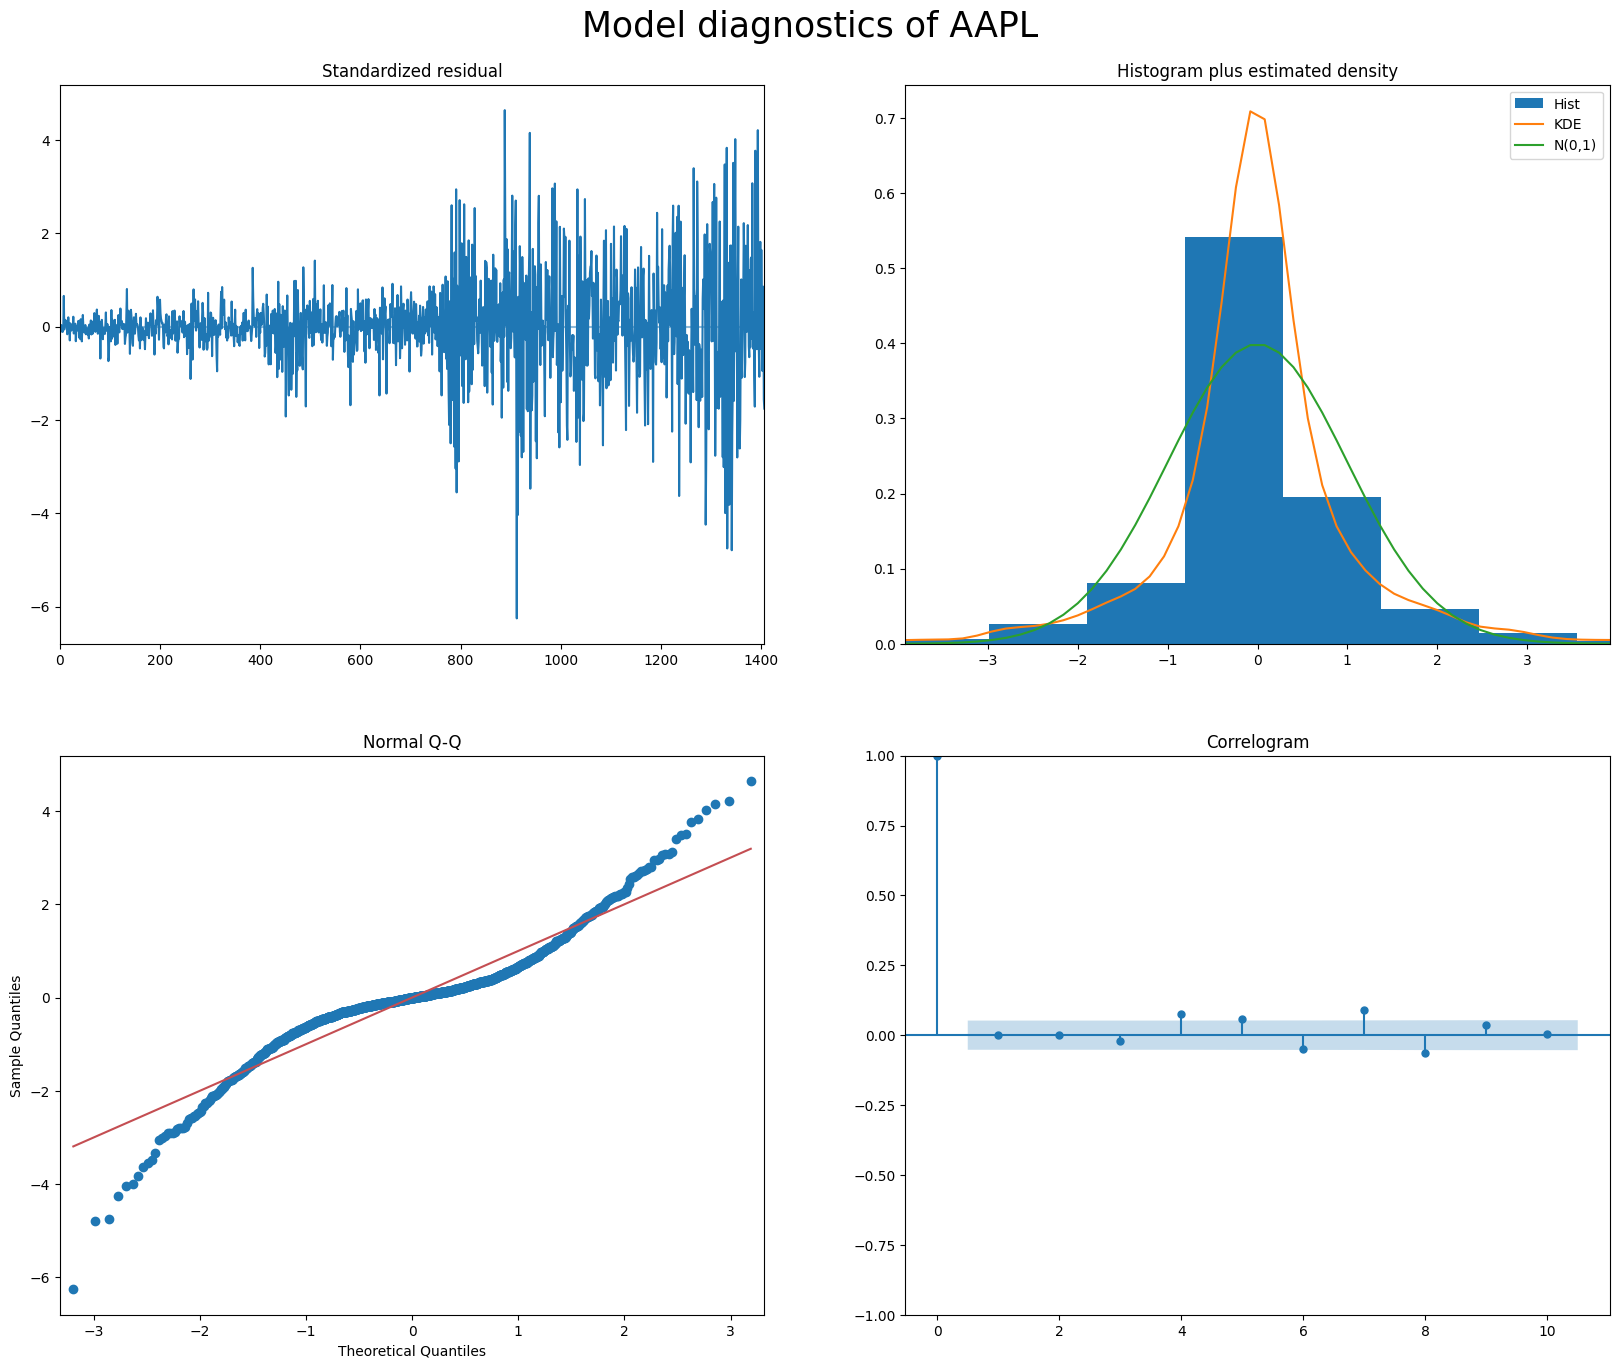

In [76]:
display_model_plots(model_apl1)

Mean absolute percentage error 19.80%


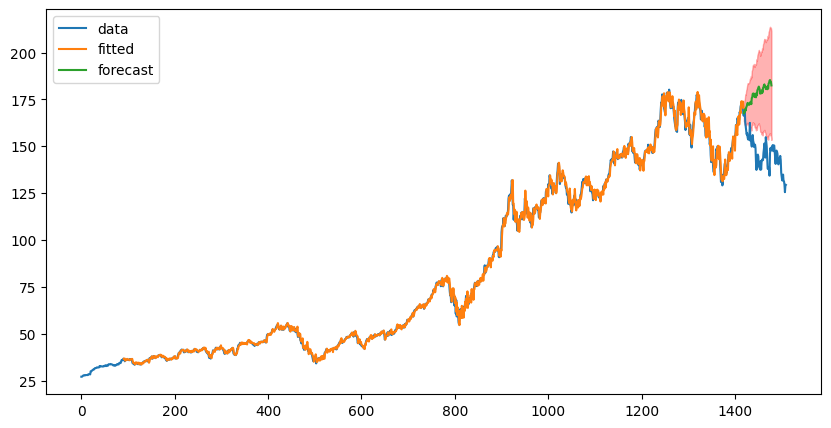

In [77]:
arima_forecast(model_apl1,apl_test,apl_train,60)

## Time Series Prediction Model

In the pursuit of an effective time series prediction model, I explored two prominent models: Facebook Prophet and SARIMA (Seasonal AutoRegressive Integrated Moving Average). Here's an overview of my choices and the rationale behind them:

### Facebook Prophet Model:

#### Why Prophet?
- **Handling Seasonality:** Prophet is known for its robust handling of seasonality in time series data. It automatically detects and models daily, weekly, and yearly seasonality patterns.
  
- **Flexibility:** Prophet is designed to work well with non-stationary and irregularly spaced data, making it suitable for various types of time series datasets.

- **Intuitive Interface:** The model's user-friendly interface simplifies the forecasting process, requiring minimal parameter tuning.

#### Performance:
- **Short and Long-Term Forecasting:** Prophet demonstrated excellent performance for both short-term and long-term forecasts. Its ability to adapt to different forecast horizons adds versatility to its application.

- **Effective Handling of Non-Stationarity:** The model effectively addressed the non-stationarity and seasonality present in the data.

### SARIMA Model:

#### Why SARIMA?
- **Statistical Rigor:** SARIMA is a statistical time series model that incorporates autoregressive, differencing, moving average, and seasonal components. It is well-suited for capturing complex temporal patterns.

- **Hyperparameter Optimization:** I used the `auto_arima` function to automatically select the optimal hyperparameters for the SARIMA model, considering seasonality and non-stationarity.

#### Performance:
- **Short-Term Performance:** SARIMA demonstrated good performance for short-term predictions, aligning well with its design for capturing intricate time series dynamics.

- **Long-Term Challenges:** However, the model's performance diminished for long-term forecasts compared to Prophet. SARIMA's effectiveness can be sensitive to the specific characteristics of the data, and it may struggle with longer forecasting horizons.

### Conclusion:

While both models showed promise, the choice between Prophet and SARIMA depends on the specific requirements of the forecasting task. For this particular analysis, the adaptive nature of Prophet in handling seasonality and non-stationarity made it a preferable choice, especially when considering both short and long-term forecasting goals.

Ultimately, the model selection process involves a trade-off between statistical rigor (SARIMA) and ease of use with robust seasonality handling (Prophet).
